#### AR(p), MA(q), ARMA(p,q) Model - Predict KOSPI 200 Financial Index
- ##### Author. Choi Sungryeol
- ##### Last Edit. 2022 - 12 - 16

In [2]:
import pandas as pd
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager, rc
import FinanceDataReader as fdr
import seaborn as sns
import time
from datetime import datetime, date
start_time = time.time()
from pandas import DataFrame
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

from scipy.stats import norm
import statsmodels.api as sm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
 
from scipy.stats import norm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import AR
import requests
import json
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [4]:
def acf_plot(data, N_LAGS, alpha):
    from statsmodels.graphics.tsaplots import plot_acf
    fig = plot_acf(data, lags=N_LAGS, alpha=alpha)
    plt.xlabel(f'Lag at 0 to {N_LAGS}')
    plt.ylabel("Lag at k's autocorrelation")
    plt.show()

In [5]:
def plot_rolling(df):
    fig, ax = plt.subplots(3,figsize=(12, 9))
    ax[0].plot(df.index, df.data, label='raw data')
    ax[0].plot(df.rolling(window=3).mean(), label="rolling mean");
    ax[0].plot(df.rolling(window=3).std(), label="rolling std (x10)");
    ax[0].legend()

    ax[1].plot(df.index, df.z_data, label="de-trended data")
    ax[1].plot(df.z_data.rolling(window=3).mean(), label="rolling mean");
    ax[1].plot(df.z_data.rolling(window=3).std(), label="rolling std (x10)");
    ax[1].legend()

    ax[2].plot(df.index, df.zp_data, label="3 lag differenced de-trended data")
    ax[2].plot(df.zp_data.rolling(window=3).mean(), label="rolling mean");
    ax[2].plot(df.zp_data.rolling(window=3).std(), label="rolling std (x10)");
    ax[2].legend()

    plt.tight_layout()
    fig.autofmt_xdate()

In [6]:
def to_datetime_format(df:pd.DataFrame, col_nm:str='index', as_index=False) -> pd.DataFrame:
    df[col_nm] = pd.to_datetime(df[col_nm], infer_datetime_format=True) #format = "%Y-%m-%d"
    df = df.sort_values(by=col_nm, ascending=True)
    if as_index:
        df.set_index(col_nm, inplace=True)
    
    return df

In [7]:
import statsmodels.api as sm
 
def embed(z, lags):
    res = []
    for i in range(lags):
        temp_z = np.expand_dims(z[lags-1-i:len(z)-i], axis=1)
        res.append(temp_z)
    res = np.concatenate(res, axis=1)
    return res
 
def get_f_stat(reduced_model, full_model):
    df_num = reduced_model.df_resid - full_model.df_resid
    df_denom = full_model.df_resid
    numerator = reduced_model.mse_resid*reduced_model.df_resid - full_model.mse_resid*full_model.df_resid
    denominator = full_model.mse_resid*full_model.df_resid
    f_stat = (numerator/df_num)/(denominator/df_denom)
    return f_stat

In [8]:
from statsmodels.tsa.stattools import adfuller

def adf_test(df):
    result = adfuller(df.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [9]:
from statsmodels.tsa.stattools import kpss

def kpss_test(df):
    statistic, p_value, n_lags, critical_values = kpss(df.values)

    print(f'KPSS Statistic: {statistic}')
    print(f'P-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f' {key} : {value}')

In [118]:
def embed(z, lags):
    res = []
    for i in range(lags):
        temp_z = np.expand_dims(z[lags-1-i:len(z)-i], axis=1)
        res.append(temp_z)
    res = np.concatenate(res, axis=1)
    return res
 
def get_f_stat(reduced_model, full_model):
    df_num = reduced_model.df_resid - full_model.df_resid
    df_denom = full_model.df_resid
    numerator = reduced_model.mse_resid*reduced_model.df_resid - full_model.mse_resid*full_model.df_resid
    denominator = full_model.mse_resid*full_model.df_resid
    f_stat = (numerator/df_num)/(denominator/df_denom)
    return f_stat
 
def augmented_df_test(y, lags, test_type=None, selectlags=None):
    '''인자 검사'''
    if test_type:
        assert test_type in ('drift', 'trend'), 'test_type must be the one of (None, drift, trend)'
    if selectlags:
        assert selectlags in ('AIC', 'BIC'), 'test_type must be the one of (None, AIC, BIC)'
    lags += 1
    z = np.diff(y)
    n = len(z)
    x = embed(z, lags)
    z_diff = x[:,0]
    z_lag_1 = y[lags-1:n]
    tt = list(range(lags, n+1))
    '''
    1. lags가 1보다 큰 경우 selectlags가 None이 아니면 AIC 또는 BIC 기준에 따라 
    차수 p를 구한다. 
    2. test_type 별로 검정을 수행한다.
    '''
    if lags > 1:
        if selectlags:
            crit_res = []
            for i in range(2, lags+1):
                z_diff_lag = x[:, 1:i]
                if test_type is None:
                    X = np.concatenate([np.expand_dims(z_lag_1,axis=1), z_diff_lag], axis=1)
                    model = sm.OLS(z_diff, X).fit()
                elif test_type == 'drift':
                    X = np.concatenate([np.expand_dims(z_lag_1,axis=1), z_diff_lag], axis=1)
                    X = sm.add_constant(X)
                    model = sm.OLS(z_diff, X).fit()
                else:
                    X = np.concatenate([np.expand_dims(z_lag_1,axis=1), np.expand_dims(tt, axis=1)], axis=1)
                    X = np.concatenate([X, z_diff_lag], axis=1)
                    X = sm.add_constant(X)
                    model = sm.OLS(z_diff, X).fit()
 
                if selectlags == 'AIC':
                    crit_res.append(model.aic)
                else:
                    crit_res.append(model.bic)
            lags = 2+np.argmin(crit_res)
        z_diff_lag = x[:, 1:lags]
        if test_type is None:
            X = np.concatenate([np.expand_dims(z_lag_1,axis=1), z_diff_lag], axis=1)
            model = sm.OLS(z_diff, X).fit()
            tau = model.tvalues[0]
            test_stat = {'tau1':tau}
        elif test_type == 'drift':
            X = np.concatenate([np.expand_dims(z_lag_1,axis=1), z_diff_lag], axis=1)
            X = sm.add_constant(X)
            model = sm.OLS(z_diff, X).fit()
            tau = model.tvalues[1]
            model_phi = sm.OLS(z_diff, z_diff_lag).fit()
 
            phi1 = get_f_stat(model_phi, model)
            test_stat = {'tau2':tau, 'phi1':phi1}
        else:
            X = np.concatenate([np.expand_dims(z_lag_1,axis=1), np.expand_dims(tt, axis=1)], axis=1)
            X = np.concatenate([X, z_diff_lag], axis=1)
            X = sm.add_constant(X)
            model = sm.OLS(z_diff, X).fit()
            tau = model.tvalues[1]
            model_phi2 = sm.OLS(z_diff, z_diff_lag).fit()
            X_temp = sm.add_constant(z_diff_lag)
            model_phi3 = sm.OLS(z_diff, X_temp).fit()
            phi2 = get_f_stat(model_phi2, model)
            phi3 = get_f_stat(model_phi3, model)
            test_stat = {'tau3':tau, 'phi2':phi2, 'phi3':phi3}
    else:
        if test_type is None:
            model = sm.OLS(z_diff, np.expand_dims(z_lag_1,axis=1)).fit()
            tau = model.tvalues[0]
            test_stat = {'tau1':tau}
        elif test_type == 'drift':
            X = np.expand_dims(z_lag_1,axis=1)
            X = sm.add_constant(X)
            model = sm.OLS(z_diff, X).fit()
            tau = model.tvalues[1]
            rss_null = np.sum(np.square(z_diff))
            df_num = len(z_diff) - model.df_resid
            df_denom = model.df_resid
            numorator = rss_null - model.mse_resid*model.df_resid
            denominator = model.mse_resid*model.df_resid
            phi1 = (numorator/df_num)/(denominator/df_denom)
            test_stat = {'tau2':tau, 'phi1':phi1}
        else:
            X = np.concatenate([np.expand_dims(z_lag_1,axis=1), np.expand_dims(tt, axis=1)], axis=1)
            X = sm.add_constant(X)
            model = sm.OLS(z_diff, X).fit()
            tau = model.tvalues[1]
 
            rss_null = np.sum(np.square(z_diff))
            df_num = len(z_diff) - model.df_resid
            df_denom = model.df_resid
            numorator = rss_null - model.mse_resid*model.df_resid
            denominator = model.mse_resid*model.df_resid
            phi2 = (numorator/df_num)/(denominator/df_denom)
            model_phi3 = sm.OLS(z_diff, [1]*len(z_diff)).fit()
            phi3 = get_f_stat(model_phi3, model)
            test_stat = {'tau3':tau, 'phi2':phi2, 'phi3':phi3}
 
#     res = model.resid
    '''샘플 사이즈에 맞는 테이블을 가져온다.'''
    if n < 25:
        rowselec = 0
    elif n < 50:
        rowselec = 1
    elif n < 100:
        rowselec = 2
    elif n < 250:
        rowselec = 3
    elif n < 500:
        rowselec = 4
    else:
        rowselec = 5
 
    if test_type is None:
        cval_tau1 = np.array([(-2.66, -1.95, -1.6),(-2.62, -1.95, -1.61),(-2.6, -1.95, -1.61),
             (-2.58, -1.95, -1.62),(-2.58, -1.95, -1.62),(-2.58, -1.95, -1.62)])
        cval = cval_tau1[rowselec, :]
        cval = np.expand_dims(cval, axis=0)
        test_name = ['tau1']
    elif test_type == 'drift':
        cval_tau2 = np.array([(-3.75, -3, -2.63),(-3.58, -2.93, -2.6),(-3.51, -2.89, -2.58),
                         (-3.46, -2.88, -2.57),(-3.44, -2.87, -2.57),(-3.43, -2.86, -2.57)])
        cval_phi1 = np.array([(7.88, 5.18, 4.12),(7.06, 4.86, 3.94),(6.7, 4.71, 3.86),
                          (6.52, 4.63, 3.81),(6.47, 4.61, 3.79),(6.43, 4.59, 3.78)])
        cval = np.array([cval_tau2[rowselec, :],cval_phi1[rowselec, :]])
        test_name = ['tau2', 'phi1']
    else:
        cval_tau3 = np.array([(-4.38, -3.6, -3.24),(-4.15, -3.5, -3.18),(-4.04, -3.45, -3.15),
                         (-3.99, -3.43, -3.13),(-3.98, -3.42, -3.13),(-3.96, -3.41,-3.12)])
        cval_phi2 = np.array([(8.21, 5.68, 4.67), (7.02, 5.13, 4.31),(6.5, 4.88, 4.16),
                             (6.22, 4.75, 4.07),(6.15, 4.71, 4.05),(6.09, 4.68, 4.03)])
        cval_phi3 = np.array([(10.61, 7.24, 5.91),(9.31, 6.73, 5.61),(8.73, 6.49, 5.47),
                              (8.43, 6.49, 5.47),(8.34, 6.3, 5.36),(8.27, 6.25, 5.34)])
        cval = np.array([cval_tau3[rowselec, :], cval_phi2[rowselec, :], cval_phi3[rowselec, :]])
        test_name = ['tau3', 'phi2', 'phi3']
 
    results = pd.DataFrame(cval)
    results.columns = ('1pct', '5pct', '10pct')
    results.insert(0, 'TEST_NAME', test_name)
    results.insert(1, 'TEST_STAT', [test_stat[x] for x in test_name])
 
    return (results, lags-1)

In [119]:
def acf(series, k):
    mean = series.mean()
    denominator = np.sum(np.square(series-mean))
    numerator = np.sum((series-mean)*(series.shift(k)-mean))
    acf_val = numerator/denominator
    return acf_val
 
def pacf(series, k):
    if k == 0:
        pacf_val = 1
    else:
        gamma_array = np.array([acf(series, k) for k in range(1,k+1)])
 
        gamma_matrix = []
        for i in range(k):
            temp = [0]*k
            temp[i:] = [acf(series, j) for j in range(k-i)]
            gamma_matrix.append(temp)
 
        gamma_matrix = np.array(gamma_matrix)
        gamma_matrix = gamma_matrix + gamma_matrix.T - np.diag(gamma_matrix.diagonal())
        pacf_val = np.linalg.inv(gamma_matrix).dot(gamma_array)[-1]
    return pacf_val

In [120]:
class autoRegressiveModel():
    def __init__(self,data,p):
        self.p = p ## 차수
        self.data = data ## 데이터
        self.mu = None ## 기대값의 추정량
        self.phi = None  ## 모수의 추정량
        self.fitted_values = None ## 적합값
        self.method = None ## 추정 방법
        self.mle_method = None ## 최대 우도 추정방법
        self.intercept = None ## 절편 추정량
        self.error_variance = None ## 백색잡음 분산
        self.log_likelihood = None ## 최대 우도 추정값
        self.std_error = None ## 모수 추정량의 표준오차
    
    def fit(self,method='Approx LS',tolerance=0.0001,grad_method='approx'):
        self.method = method
        valid_methods = ['Approx LS','Non-linear LS','YW','CMLE','EMLE']
        assert method in valid_methods, \
        f'method argument must be the one of {valid_methods}'
        
        ## 1) 모수 추정
        if method == 'Approx LS':
            self._fit_approx_ls()
        elif method == 'Non-linear LS':
            self._fit_nonlinear_ls(tolerance)
        elif method == 'YW':
            self._fit_yw()
        else:
            self._fit_mle(tolerance=tolerance,method=method,grad_method=grad_method)
        
        ## 2) 모형 적합값 계산
        self.fitted_values = self._fitted_values(self.phi,self.mu)
        
        ## 3) 백색 잡음 분산 추정량 계산
        if method == 'EMLE':
            pass
        else:
            self.error_variance = self._get_error_variance(self.phi,self.mu,method)
            
        ## 4) 표준 오차 계산
        ev = self.error_variance
        auto_cov_matrix = self._auto_cov_matrix()
        self.std_error = np.sqrt(ev*np.linalg.inv(auto_cov_matrix)/len(self.data)).squeeze()+0

    def _fitted_values(self,phi,mu):
    	## 적합값 계산 함수
        data = self.data
        p = self.p
        y = data[p:] - mu
        n = len(data)
        X = []
        for i in range(n-p):
            row = data[i:i+p][::-1]-mu
            X.append(row)
 
        X = np.array(X)
        return X.dot(phi) + mu

    def _get_error_variance(self,phi,mu,method):
        ## 백색 잡음 분산 계산
        data = self.data
        p = self.p
        n = len(data)
        y = data[p:]
        if method == 'YW':
            sacf = []
            svar = np.var(data)
            for k in range(1,p+1):
                sacf.append(self.sample_acf(k))
                
            sacf = np.array(sacf)
            error_variance = svar-phi.dot(sacf)#### to change
        else:
            error_variance = np.sum(np.square(y - self._fitted_values(phi,mu)))/(n-p)
        return error_variance
    def _fit_approx_ls(self):
        data = self.data
        p = self.p
        n = len(data)
        
        mu = np.mean(data) ## estimate mu
        y = data[p:] - mu
        X = []
        for i in range(n-p):
            row = data[i:i+p][::-1]-mu
            X.append(row)
 
        X = np.array(X)
 
        X_tX = X.T.dot(X)
        X_tX_inv = np.linalg.inv(X_tX)
        phi = X_tX_inv.dot(X.T.dot(y))
        self.mu = mu
        self.phi = phi
        self.intercept = mu*(1-np.sum(phi))


    def _fit_nonlinear_ls(self, tolerance):
        data = self.data
        self._fit_approx_ls()
        phi = self.phi
        p = self.p
        mu = self.mu
        n = len(data)
        data = self.data
        
        cur_beta = np.insert(phi,0,mu) ## initial parameter vector
        f = lambda x, beta : beta[0] + beta[1:].dot(x-beta[0])
        y = data[p:]
        while True:
            delta_ys = []
            J = []
            for i in range(n-p):
                x = data[i:i+p][::-1]
                delta_y = y[i] - f(x,cur_beta)
                delta_ys.append(delta_y)
                J_row = []
                for j in range(len(cur_beta)):
                    if j == 0:
                        J_element = 1-np.sum(cur_beta[1:])
                    else:
                        J_element = x[j-1]-cur_beta[0]
                    J_row.append(J_element)
                J.append(J_row)
 
            J = np.array(J)
            delta_ys = np.array(delta_ys)
 
            J_tJ = J.T.dot(J)
            J_tJ_inv = np.linalg.inv(J_tJ)
 
            delta_beta = J_tJ_inv.dot(J.T.dot(delta_ys))
 
            next_beta = cur_beta+delta_beta
            if np.max((next_beta-cur_beta)/cur_beta) < tolerance:
                self.mu = next_beta[0]
                self.phi = next_beta[1:]
                self.intercept = mu*(1-np.sum(self.phi))
                break
            else:
                cur_beta = next_beta

    def sample_acf(self,k):
        data = self.data
        mu = np.mean(data)
        
        n = len(data)
        data = data - mu
        summand = 0
        for j in range(k,n):
            summand += data[j]*data[j-k]
        return summand/n
    def _auto_cov_matrix(self):
        data = self.data
        p = self.p
        diag_element = np.array([self.sample_acf(0)]*p)
        C = np.diag(diag_element) ## sample autocovariace function를 원소로하는 matrix
        if p>1:
            for i in range(p-1):
                for j in range(i+1,p):
                    C[i][j] = self.sample_acf(j-i)
                    C[j][i] = self.sample_acf(j-i)
                    
        return C
        
    def _fit_mle(self,tolerance,method='CMLE',max_iter=20,grad_method='approx'):
        valid_methods = ['CMLE','EMLE']
        assert method in valid_methods,\
        f'method must be the one of {valid_methods}'
        valid_grad = ['approx','exact']
        assert grad_method in valid_grad,\
        f'method must be the one of {valid_grad}'
        
        self.mle_method = method
        data = self.data
        p = self.p
        n = len(data)
        if method == 'CMLE':
            self._fit_nonlinear_ls(tolerance)
        else:
            self._fit_nonlinear_ls(tolerance)
            
            ### initial value
            cur_phi = self.phi
            cur_c = self.intercept
            cur_mu = cur_c/(1-np.sum(cur_phi))
            cur_est_variance = self._get_error_variance(cur_phi,cur_mu,method=None)
            cur_params = np.insert(cur_phi,0,cur_c)
            hess = -self._approx_hess(cur_params,\
                                    self._get_log_likelihood,cur_est_variance)
            cur_A = np.linalg.inv(hess)
            iter_cnt = 1
            max_val = -np.infty
            while iter_cnt <= max_iter:
                ### grid search for finding good step size
                is_improved = False
                step = np.array([1,2,4,8,16])
                step = np.concatenate([np.arange(0,1,0.01),step])
                if grad_method == 'exact':
                    grad = self._get_first_derivative_log_likelihood(cur_params,cur_est_variance)
                else:                     
                    grad = self._approx_fdlh(cur_params,cur_est_variance)
                    
                for s in step:
                    temp_params = cur_params+s*cur_A.dot(grad)
                    obj_val = self._get_log_likelihood(temp_params,cur_est_variance)
                    if obj_val > max_val:
                        is_improved = True
                        max_val = obj_val
                        opt_s = s
                    
                next_params = cur_params+opt_s*cur_A.dot(grad)
                diff_params = next_params - cur_params
                diff_params = np.expand_dims(diff_params,axis=1)
                next_mu = next_params[0]/(1-np.sum(next_params[1:]))
                residuals = data[p:]-self._fitted_values(next_params[1:],next_mu)
                
                next_est_variance = np.sum(np.square(residuals))/n
                next_vp = self._get_inverse_vp(next_params[1:])
                prior_res = data[:p]-np.array([next_mu]*p)
                next_est_variance += prior_res.dot(next_vp.dot(prior_res))/n
                
                if grad_method == 'exact':
                    next_grad = self._get_first_derivative_log_likelihood(next_params,next_est_variance)
                else:
                    next_grad = self._approx_fdlh(next_params,next_est_variance)
                
                diff_grad = next_grad - grad
                diff_grad = np.expand_dims(diff_grad,axis=1)
                next_A = cur_A - \
                    cur_A.dot(diff_grad.dot(diff_grad.T.dot(cur_A)))/(diff_grad.T.dot(cur_A.dot(diff_grad))) \
                    -diff_params.dot(diff_params.T)/(diff_grad.T.dot(diff_params))
                
                if not is_improved:
                    self.phi = cur_params[1:]
                    self.mu = cur_params[0]/(1-np.sum(self.phi))
                    self.intercept = cur_params[0]
                    self.log_likelihood = max_val
                    self.error_variance = cur_est_variance
                    break
                elif np.max(np.abs(diff_params/cur_params)) < tolerance or not self.is_pos_def(next_A):
                    self.phi = next_params[1:]
                    self.mu = next_params[0]/(1-np.sum(self.phi))
                    self.intercept = next_params[0]
                    self.log_likelihood = max_val
                    self.error_variance = next_est_variance
                    break                
                else:
                    cur_params = next_params
                    cur_est_variance = next_est_variance
                    cur_A = next_A
                     
                iter_cnt += 1
    def _get_inverse_vp(self,phi):
        if not isinstance(phi,np.ndarray):
            phi = np.array(phi)
        p = self.p
        assert len(phi) == p, f'order{p} do not equal to length of phi vector({len(phi)})'
        inverse_vp = np.zeros((p,p))
        for i in range(p):
            for j in range(i,p):
                first_part_left_phis = np.insert(phi[:i],0,-1)
                if i == j:
                    first_part_right_phis = first_part_left_phis
                else:
                    first_part_right_phis = phi[j-i-1:j]
 
                seconde_part_left_phis = phi[p-j-1:p+i-j]
                seconde_part_right_phis = phi[p-i-1:p]
                if i == j:
                    inverse_vp[i][j] = 0.5*(first_part_left_phis.dot(first_part_right_phis) - \
                                seconde_part_left_phis.dot(seconde_part_right_phis))
                else:
                    inverse_vp[i][j] = first_part_left_phis.dot(first_part_right_phis) - \
                                seconde_part_left_phis.dot(seconde_part_right_phis)
 
        inverse_vp = inverse_vp+inverse_vp.T ## make symmetric matrix
        return inverse_vp
    
    def _get_first_derivative_log_likelihood(self,params,est_variance):
        ## check
        c = params[0]
        phi = params[1:]
        data = self.data
        n = len(data)
        p = self.p
        inverse_vp = self._get_inverse_vp(phi)
        x = data[:p]
 
        mu = c/(1-np.sum(phi))
 
        dmu_dphi = c/np.square((1-np.sum(phi)))
 
        ##### calculate dl_dc
        dmu_dc = 1/(1-np.sum(phi))
 
        ### second part derivative w.r.t c
        temp1 = 0
        for i in range(p):
            for j in range(p):
                temp1 += x[i]*inverse_vp[i][j]
        dsecond_dc = (dmu_dc*temp1 - mu*dmu_dc*np.sum(inverse_vp))/est_variance
 
        ### third part derivative w.r.t c
        temp2 = 0
        for t in range(p,n):
            res = data[t] - c - data[t-p:t][::-1].dot(phi)
            temp2 += res
 
        dthird_dc = temp2/est_variance
        dl_dc = dsecond_dc + dthird_dc
 
        ##### calculate dl_dphi
        dl_dphi = []
        for m in range(p):
            ####### term 하나씩 비교해보자 손으로 풀어서
            #### first part derivative w.r.t phi[m]
            temp3 = np.zeros((p,p))
            for i in range(p):
                for j in range(i,p):
                    temp3[i][j] = self.dvp_dphi(phi,m,i,j)
 
            dvp_dphi_matrix = temp3 + temp3.T - \
                np.diag(np.diagonal(temp3))
 
            vp = np.linalg.inv(inverse_vp)
            dfirst_dphi = 0.5*np.sum(np.diagonal(vp.dot(dvp_dphi_matrix)))
 
            #### second part derivative w.r.t phi[m]
            spdp = 2*mu*dmu_dphi*np.sum(inverse_vp) + np.square(mu)*np.sum(dvp_dphi_matrix)
            for i in range(p):
                for j in range(p):
                    spdp -= 2*dmu_dphi*x[i]*inverse_vp[i][j] + 2*mu*x[i]*dvp_dphi_matrix[i][j]
                    spdp += x[i]*x[j]*dvp_dphi_matrix[i][j]
            dsecond_dphi = (-0.5)*spdp/est_variance
 
            #### third part derivative w.r.t phi[m]
            temp4 = 0
            for t in range(p,n):
                res = (data[t] - c - data[t-p:t][::-1].dot(phi))*data[t-m-1]
                temp4 += res
 
            dthird_dphi = temp4/est_variance
            dl_dphi.append(dfirst_dphi+dsecond_dphi+dthird_dphi)
        return np.array([dl_dc]+dl_dphi)
    
    def _get_log_likelihood(self,params,est_variance):
        c = params[0]
        phi = params[1:]
        data = self.data
        p = self.p
        n = len(data)
        x = data[:p]
        mu = np.array([c/(1-np.sum(phi))]*p)
 
        inverse_vp = self._get_inverse_vp(phi)
#         print('in vp', inverse_vp)
#         print('mu',mu)
        temp = 0
        temp += -0.5*n*np.log(2*np.pi*est_variance)
        temp += 0.5*np.log(np.linalg.det(inverse_vp))
        temp += -0.5*(x-mu).dot(inverse_vp.dot(x-mu))/est_variance
        temp2 = 0
        for t in range(p,n):
            res = data[t] - c - data[t-p:t][::-1].dot(phi)
            temp2 += np.square(res)
 
        temp -= 0.5*temp2/est_variance
        return temp
    
    def _approx_hess(self,x,func,*args,epsilon=0.001):
        m = len(x)
        approx_hess_matrix = np.zeros((m,m))
        for i in range(m):
            for j in range(i,m):
                e_i = np.zeros(m)
                e_i[i] = 1
                e_j = np.zeros(m)
                e_j[j] = 1
                temp = (0.25/np.square(epsilon))*\
                ((func(x+epsilon*e_i+epsilon*e_j,*args)-func(x+epsilon*e_i-epsilon*e_j,*args))-\
                (func(x-epsilon*e_i+epsilon*e_j,*args)-func(x-epsilon*e_i-epsilon*e_j,*args)))
                approx_hess_matrix[i][j] = temp
 
        approx_hess_matrix = approx_hess_matrix + approx_hess_matrix.T -\
                            np.diag(np.diagonal(approx_hess_matrix))
        return approx_hess_matrix
    
    def _approx_grad(self,x,func,*args,epsilon=0.000001):
        temp = []
        for i in range(len(x)):
            e = np.zeros(len(x))
            e[i] = 1
            diff = (func(x+epsilon*e,*args) - func(x,*args))/epsilon
            temp.append(diff)
            
        return np.array(temp)
    
    def _approx_fdlh(self,x,*args):
        return self._approx_grad(x,self._get_log_likelihood,*args)
    
    def is_pos_def(self,x):
        return np.all(np.linalg.eigvals(x) > 0)
    
    def dvp_dphi(self,phi,m,i,j):
        p = self.p
        temp = 0
        if i==j:
            if i >= 1:
                if m <= i-1:
                    temp += 2*phi[m]
 
            if m >= p-j-1 and m <= p-1:
                temp -= 2*phi[m]
        elif i<j:
            if i >= 1:
                if m <= i-1:
                    temp += phi[m+j-i]
            if m >= j-i-1 and m <= j-1:
                if m-j+i < 0:
                    temp -= 1
                else:
                    temp += phi[m-j+i]
            if m >= p-j-1 and m <= p+i-j-1:
                temp -= phi[m+j-i]
            if m >= p-i-1 and m <= p-1:
                temp -= phi[m-j+i]
        return temp
    def predict(self,k):
        assert k > 0, 'k must be positive integer'
        c = self.intercept
        phi = self.phi
        data = self.data
        data = data[::-1]
        return np.array([self._predict(j,c,phi,data) for j in range(1,k+1)])
    def _predict(self,k,c,phi,data):
        global predict_value
        predict_value = c
        p = len(phi)
        for j in range(p):
            if k-j-1<=0:
                predict_value += phi[j]*data[1+j-k]
            else:
                predict_value += phi[j]*self._predict(k-j-1,c,phi,data)
        return predict_value
    def _prediction_variances(self,k):
        assert k > 0, 'k must be positive integer'
        phi = self.phi
        error_variance = self.error_variance
        return np.array([self._prediction_variance(j,error_variance,phi) for j in range(1,k+1)])
    
    def _prediction_variance(self,k,error_variance,phi):
        global prediction_variance
        prediction_variance = error_variance
        p = len(phi)
        for j in range(p):
            if k-j-1<=0:
                pass
            else:
                prediction_variance += np.square(phi[j])*\
                self._prediction_variance(k-j-1,error_variance,phi)
        return prediction_variance
    def predict_interval(self,k,alpha=0.05):
        upper_limits = []
        lower_limits = []
        for j in range(1,k+1):
            limit = self._predict_interval(j,alpha)
            upper_limits.append(limit[1])
            lower_limits.append(limit[0])
        return lower_limits, upper_limits
    
    def _predict_interval(self,k,alpha):
        c = self.intercept
        phi = self.phi
        data = self.data
        data = data[::-1]
        error_variance = self.error_variance
        pred = self._predict(k,c,phi,data)
        pv = self._prediction_variance(k,error_variance,phi)
        upper_limit = pred+norm.ppf(1-alpha/2)*np.sqrt(pv)
        lower_limit = pred-norm.ppf(1-alpha/2)*np.sqrt(pv)
        return lower_limit, upper_limit


In [121]:
csv_list = list(filter(lambda x : x.split('.')[-1] == 'csv', os.listdir()))
print(csv_list)
df = pd.DataFrame()
for file in csv_list:
    tmp_df = pd.read_csv(file, thousands = ',')
    df = pd.DataFrame(tmp_df.iloc[:,[0,1]])
    df.columns = ["date", "close"]
    print(df)
df["date"] = pd.to_datetime(df["date"])
print(df.dtypes)

['KOSPI_200.csv']
           date   close
0    2010-08-01  777.29
1    2010-09-01  797.54
2    2010-10-01  789.57
3    2010-11-01  807.79
4    2010-12-01  920.57
..          ...     ...
144  2022-08-01  590.34
145  2022-09-01  523.53
146  2022-10-01  560.70
147  2022-11-01  626.83
148  2022-12-01  624.00

[149 rows x 2 columns]
date     datetime64[ns]
close           float64
dtype: object


In [122]:
pd.DataFrame(df["close"].describe(include='all'))

,close
count,149.000000
mean,709.840537
std,93.411799
min,455.590000
25%,662.240000
50%,712.450000
75%,751.700000
max,943.180000


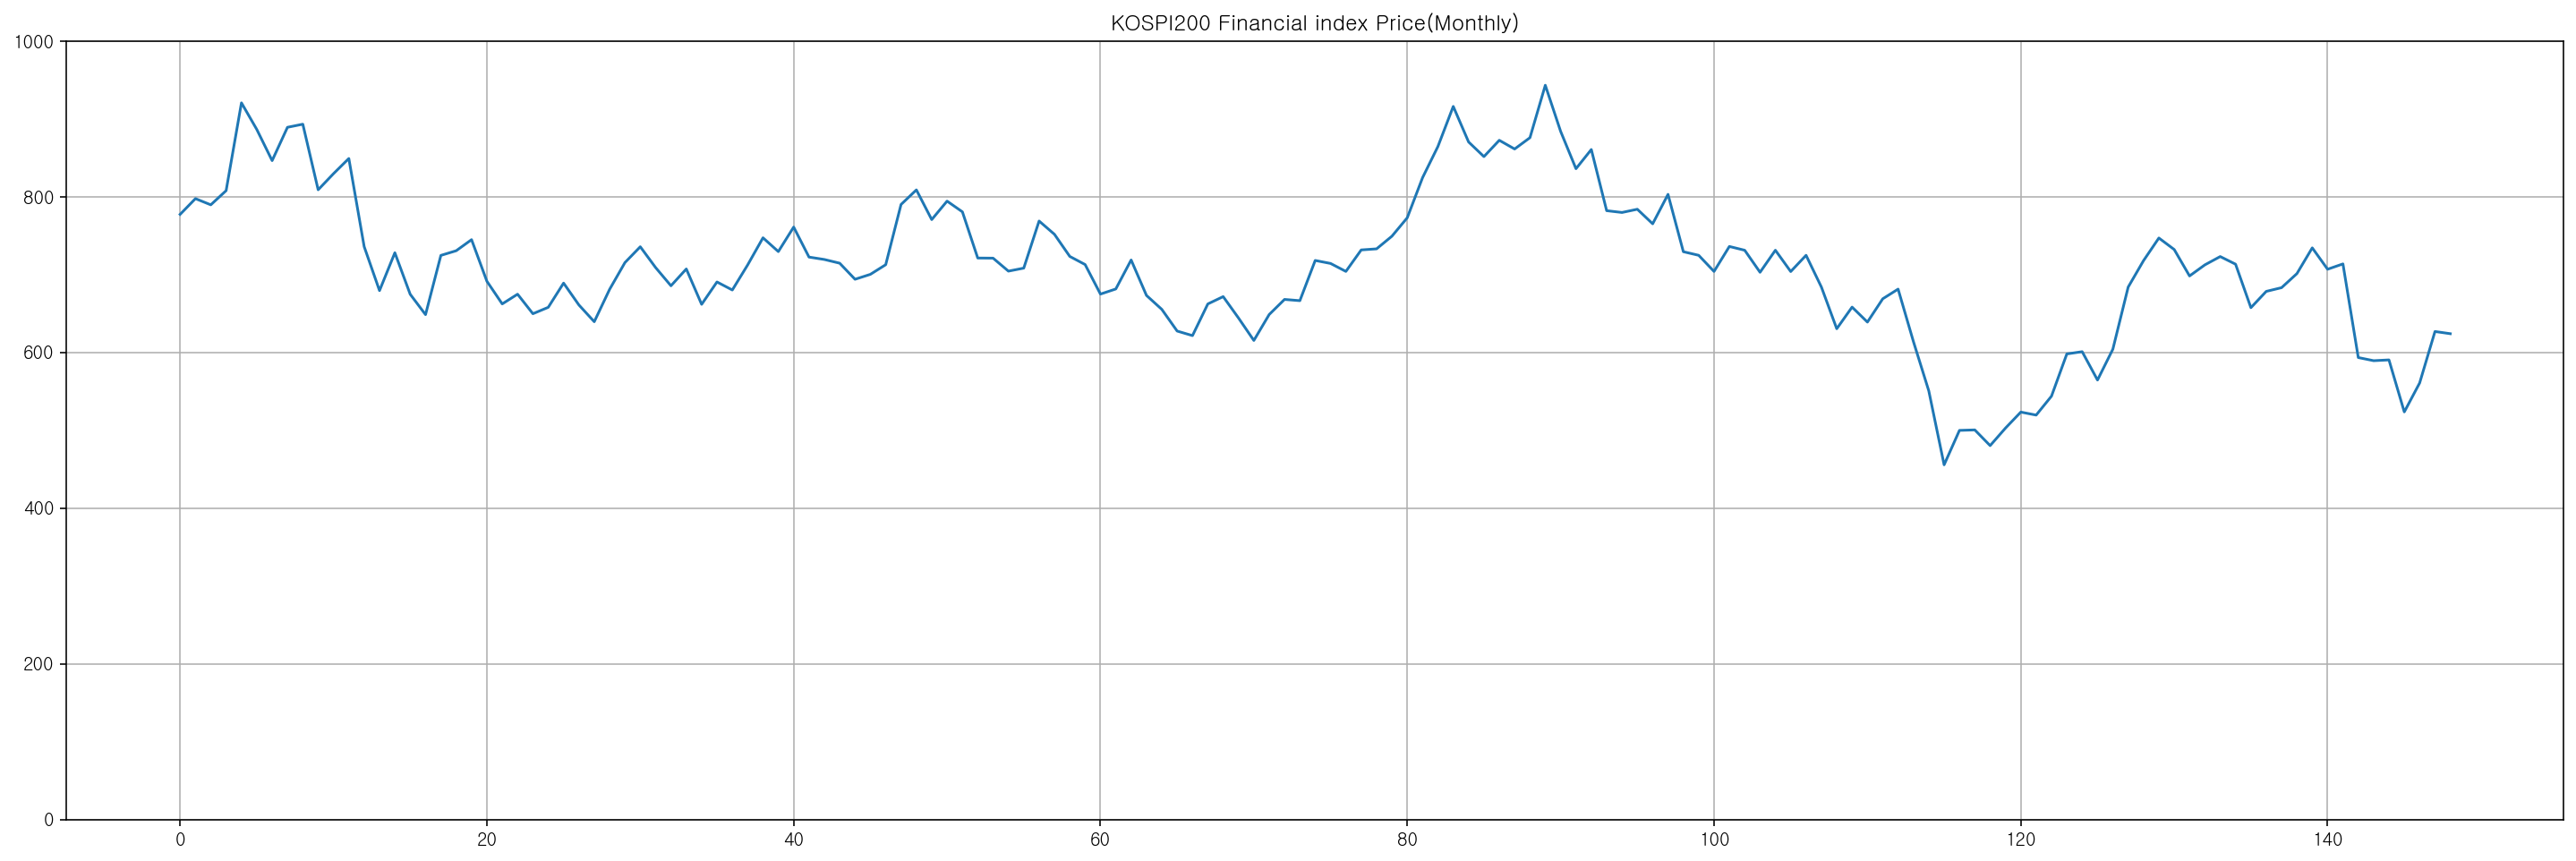

In [123]:
plt.figure(figsize=(25,8))
plt.ylim([0,1000])
plt.plot(df["close"], linewidth = 1.5)
plt.title("KOSPI200 Financial index Price(Monthly)")
plt.grid(True)
plt.show()

In [124]:
df["year"] = [d.year for d in df.date]
df["month"] = [d.strftime('%b') for d in df.date]
years = df["year"].unique()
np.random.seed(153)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace = False)

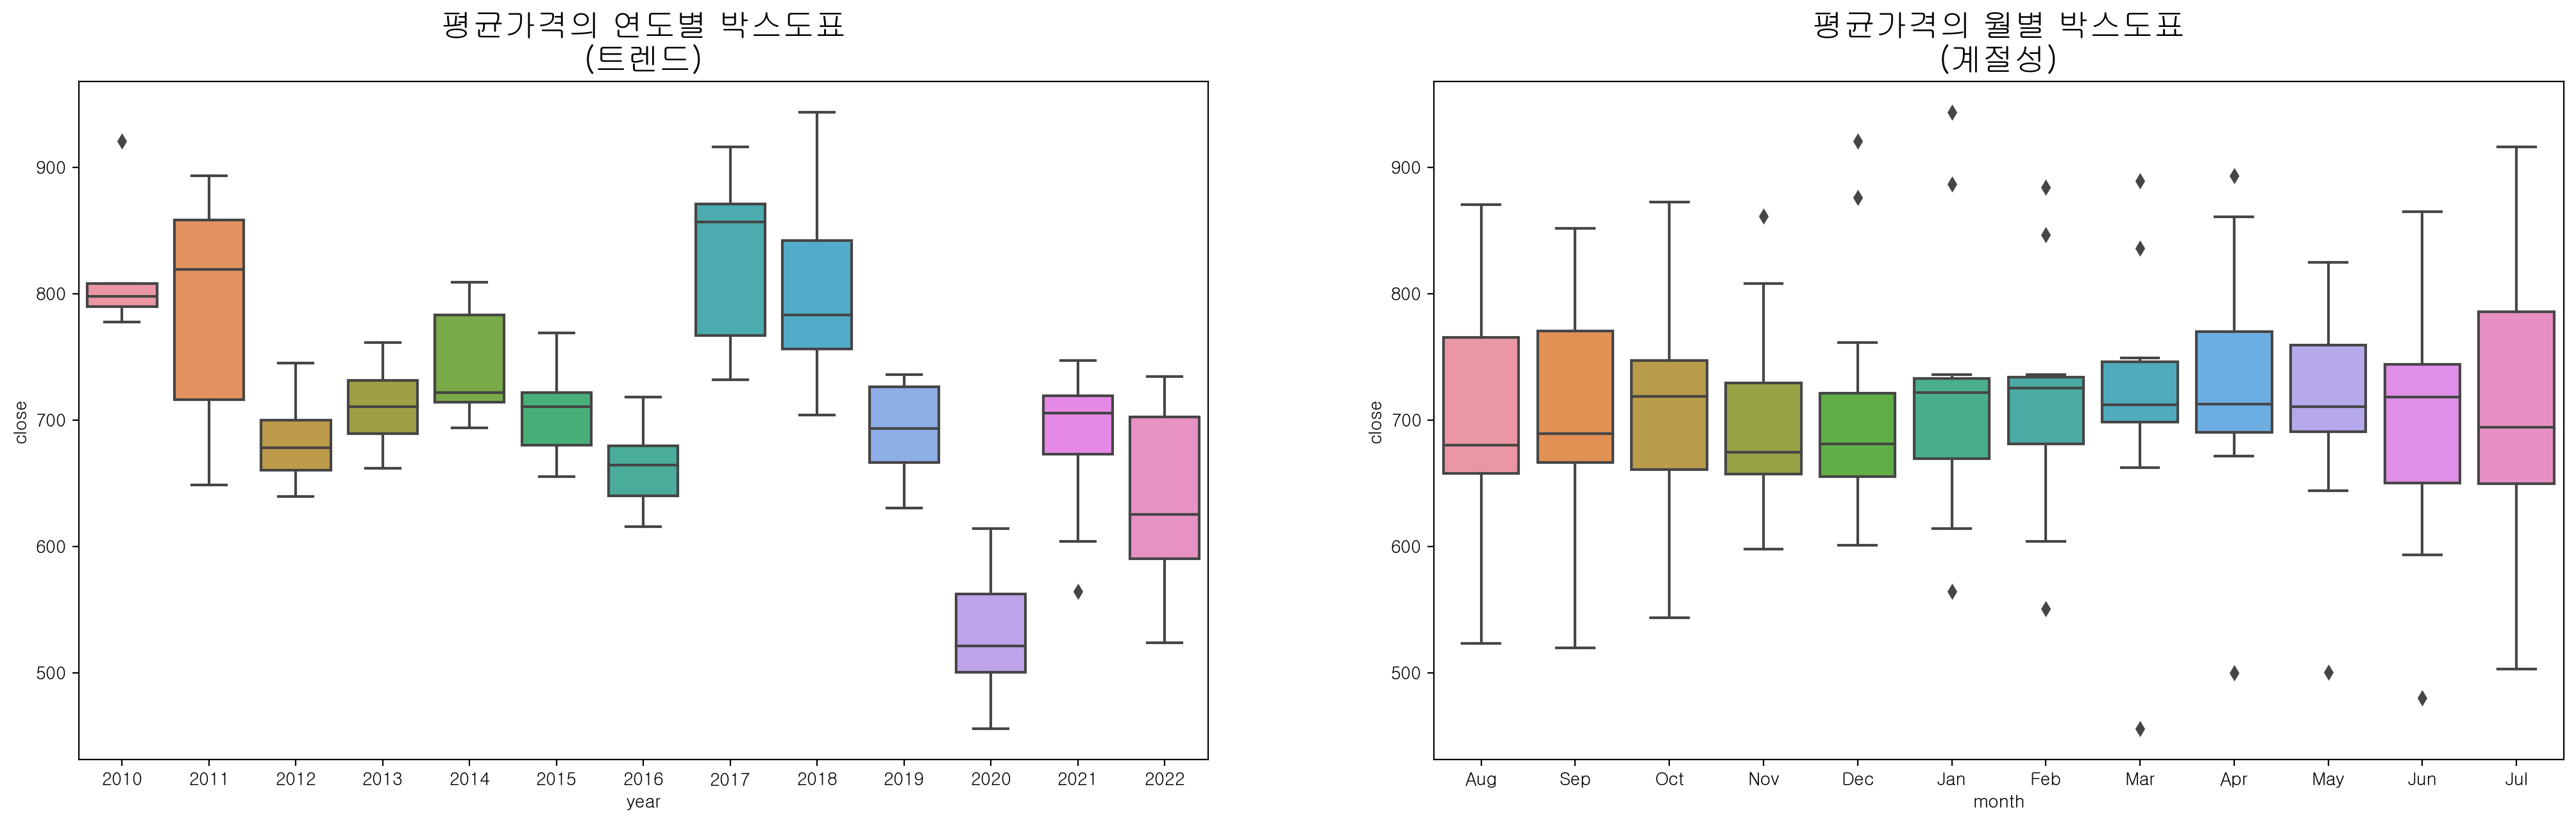

In [125]:
fig, axes = plt.subplots(1, 2, figsize=(25,7), dpi= 100)
sns.boxplot(x='year', y=df.iloc[:,1], data=df, ax=axes[0])
sns.boxplot(x='month', y=df.iloc[:,1], data=df, ax=axes[1])
axes[0].set_title('평균가격의 연도별 박스도표\n(트렌드)', fontsize=18)
axes[1].set_title('평균가격의 월별 박스도표\n(계절성)', fontsize=18)
plt.show()

<Figure size 432x288 with 0 Axes>

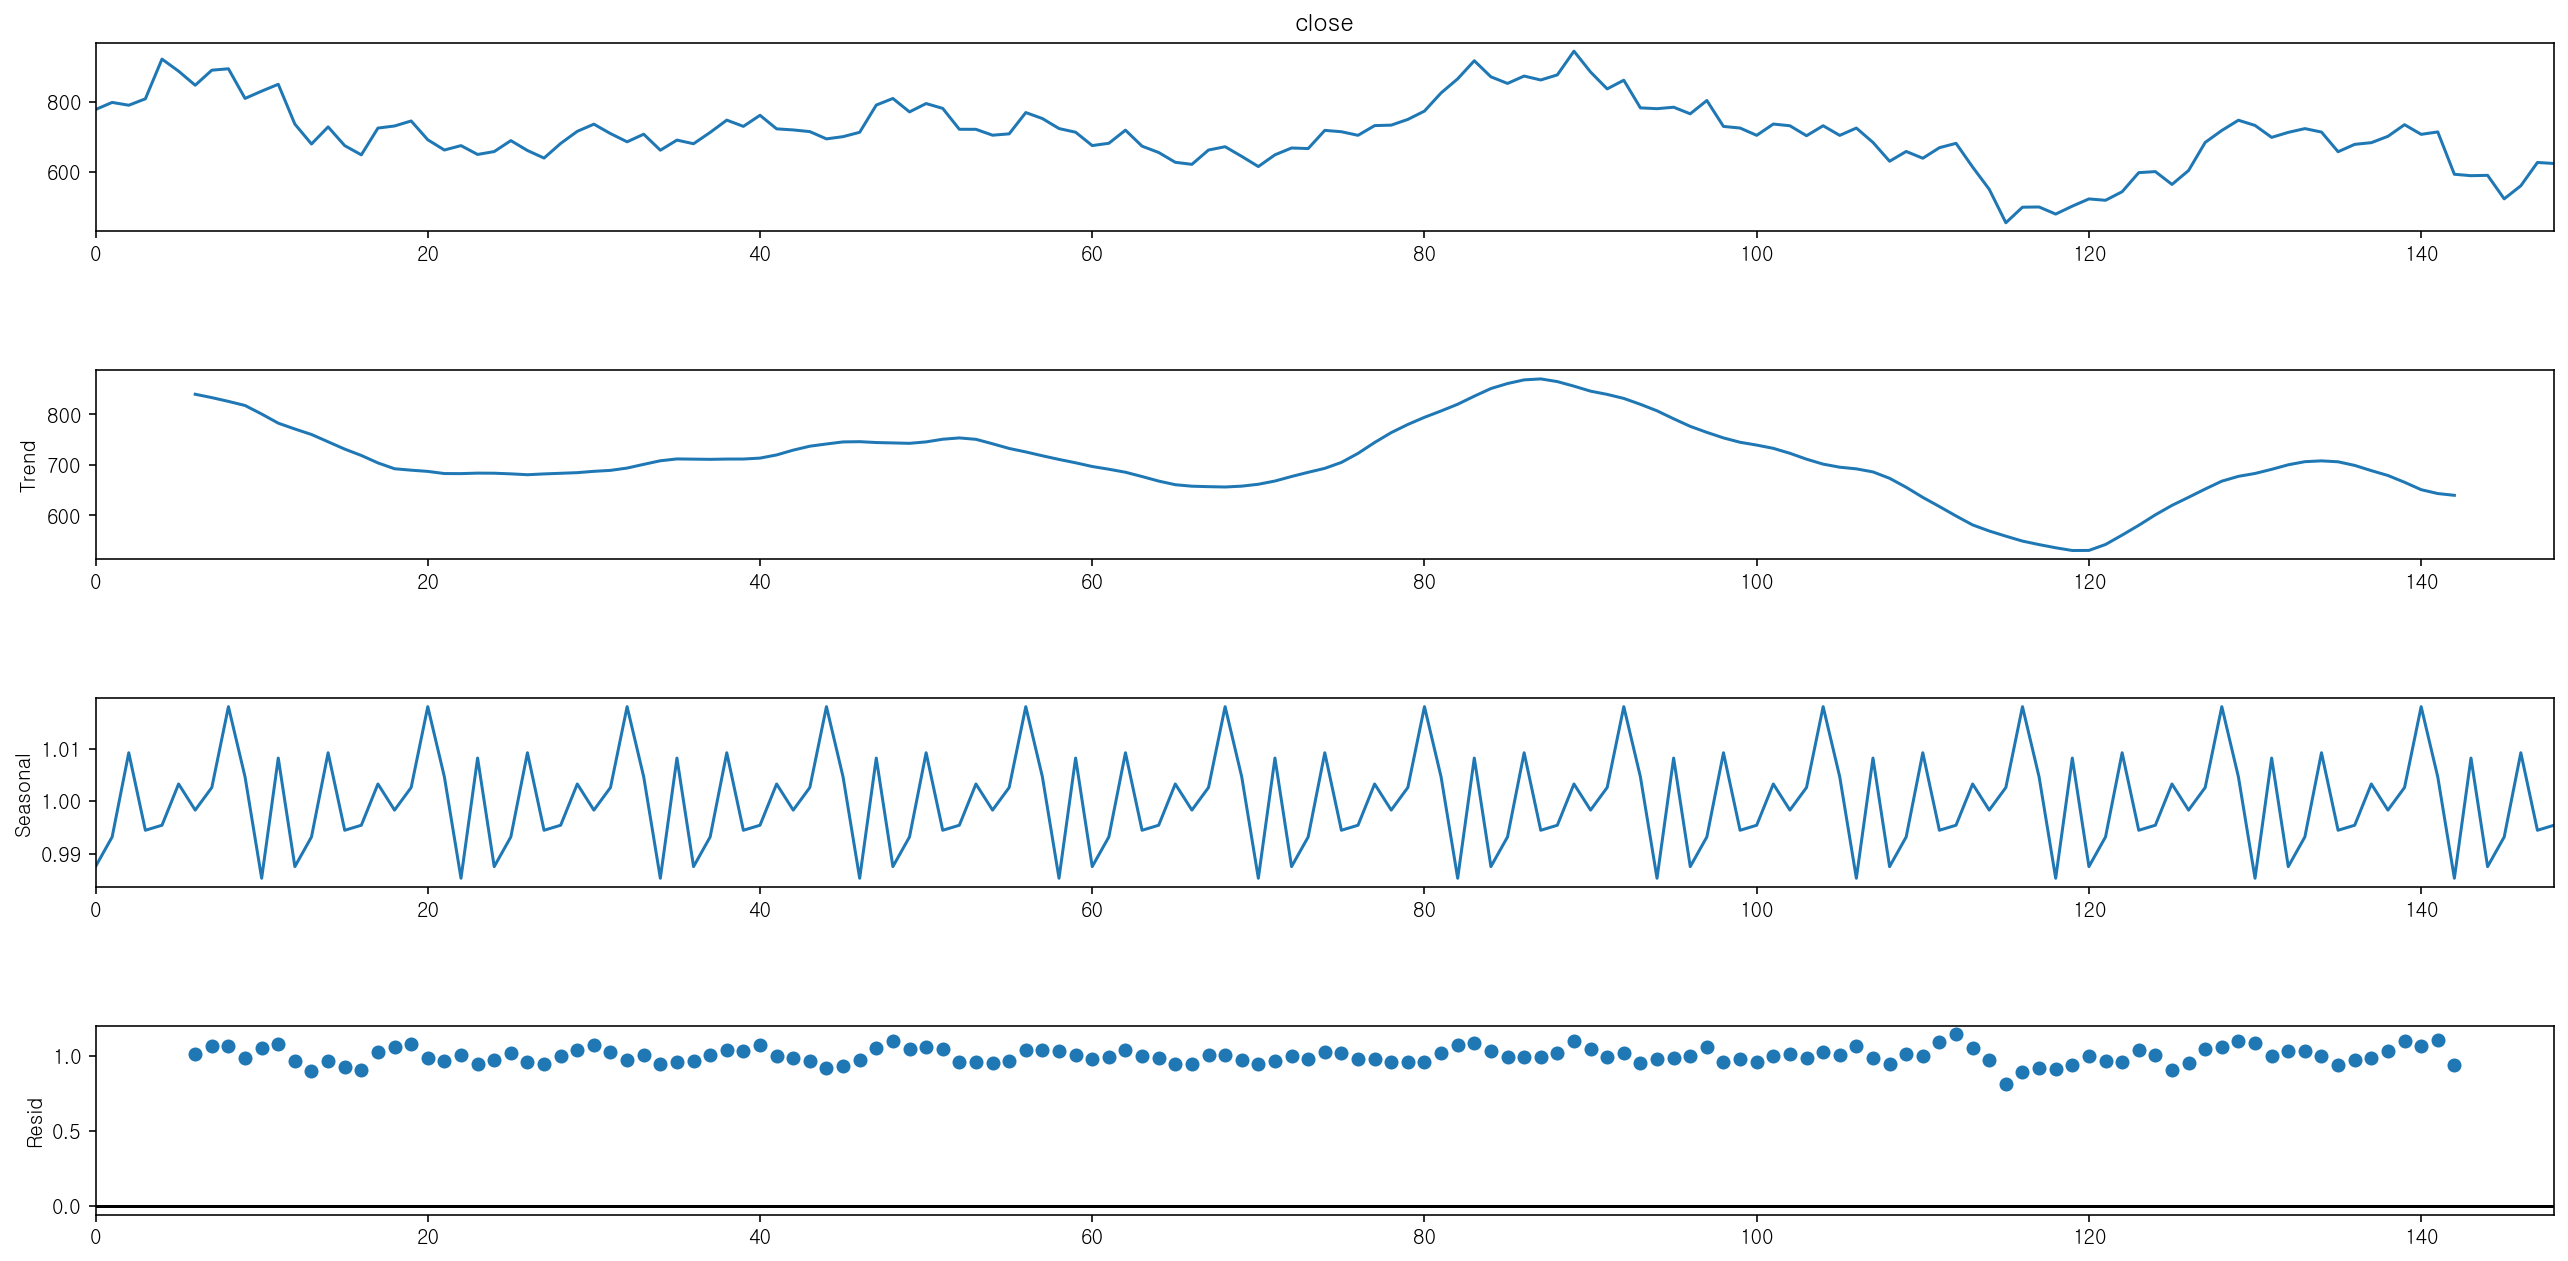

In [126]:
revenued = df.loc[:,"close"]
result = seasonal_decompose(revenued, model='multiplicative', period=12)

fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,10)

In [127]:
df

,date,close,year,month
0,2010-08-01,777.29,2010,Aug
1,2010-09-01,797.54,2010,Sep
2,2010-10-01,789.57,2010,Oct
3,2010-11-01,807.79,2010,Nov
4,2010-12-01,920.57,2010,Dec
...,...,...,...,...
144,2022-08-01,590.34,2022,Aug
145,2022-09-01,523.53,2022,Sep
146,2022-10-01,560.70,2022,Oct
147,2022-11-01,626.83,2022,Nov


In [128]:
print('ADF TEST: Spanich Price time series')
print('Null hypothesis: Time Series are Not Stationary ')
print('Alternative hypothesis: Time Series are Stationary (When p-value < 0.05) ')
adf_test(df['close'])

ADF TEST: Spanich Price time series
Null hypothesis: Time Series are Not Stationary 
Alternative hypothesis: Time Series are Stationary (When p-value < 0.05) 
ADF Statistics: -2.420814
p-value: 0.135948
Critical values:
	1%: -3.480
	5%: -2.883
	10%: -2.578


## Seasonal Adjustment

In [129]:
log_diff = df
log_diff.iloc[:,1] = np.log(log_diff.iloc[:,1])
log_diff.iloc[:,1] = log_diff.iloc[:,1].diff(1)
log_diff = log_diff.iloc[1:,]

In [130]:
log_diff

,date,close,year,month
1,2010-09-01,0.025718,2010,Sep
2,2010-10-01,-0.010043,2010,Oct
3,2010-11-01,0.022814,2010,Nov
4,2010-12-01,0.130691,2010,Dec
5,2011-01-01,-0.037870,2011,Jan
...,...,...,...,...
144,2022-08-01,0.001695,2022,Aug
145,2022-09-01,-0.120104,2022,Sep
146,2022-10-01,0.068592,2022,Oct
147,2022-11-01,0.111489,2022,Nov


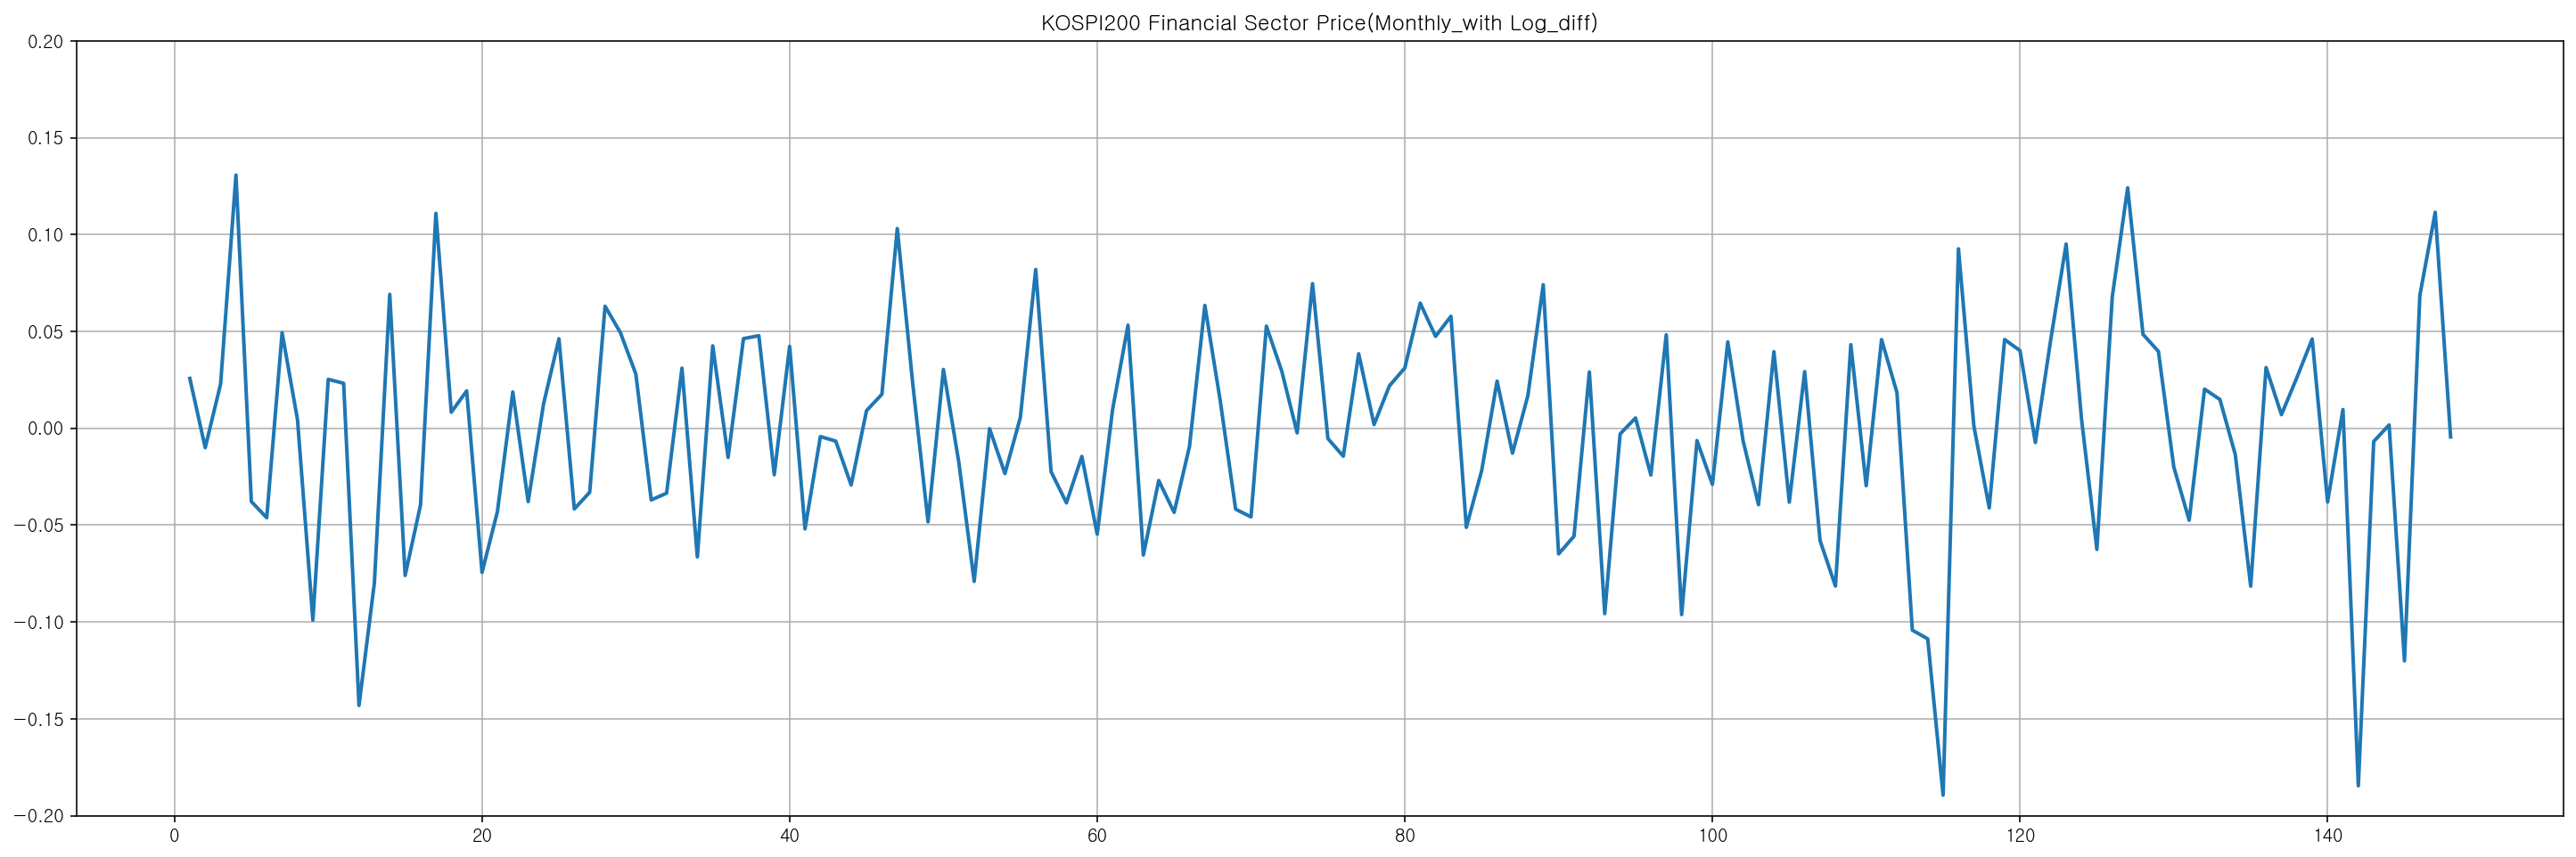

In [131]:
plt.figure(figsize=(25,8))
plt.ylim([-0.2,0.2])
plt.plot(log_diff["close"], linewidth = 2)
plt.title("KOSPI200 Financial Sector Price(Monthly_with Log_diff)")
plt.grid(True)
plt.show()

In [132]:
print('ADF TEST: Spanich Price time series')
print('Null hypothesis: Time Series are Not Stationary ')
print('Alternative hypothesis: Time Series are Stationary (When p-value < 0.05) ')
adf_test(log_diff['close'])

ADF TEST: Spanich Price time series
Null hypothesis: Time Series are Not Stationary 
Alternative hypothesis: Time Series are Stationary (When p-value < 0.05) 
ADF Statistics: -3.796724
p-value: 0.002941
Critical values:
	1%: -3.480
	5%: -2.883
	10%: -2.578


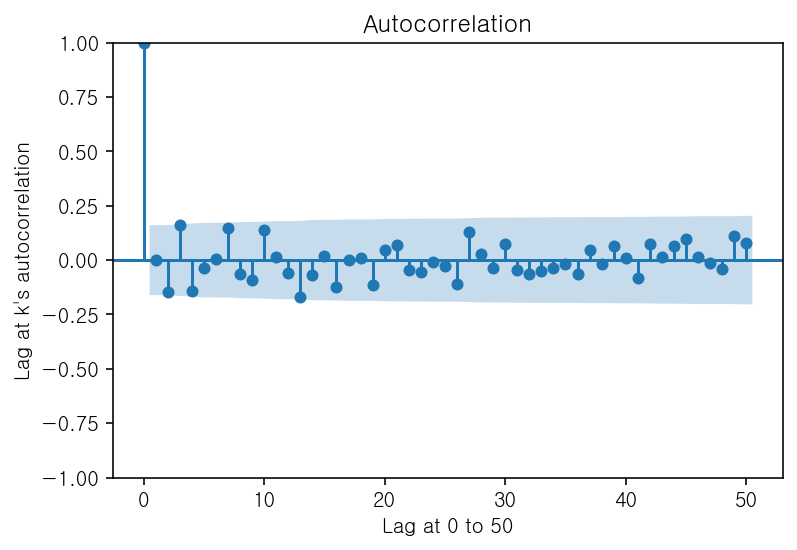

In [133]:
acf_plot(log_diff["close"], 50, 0.05)

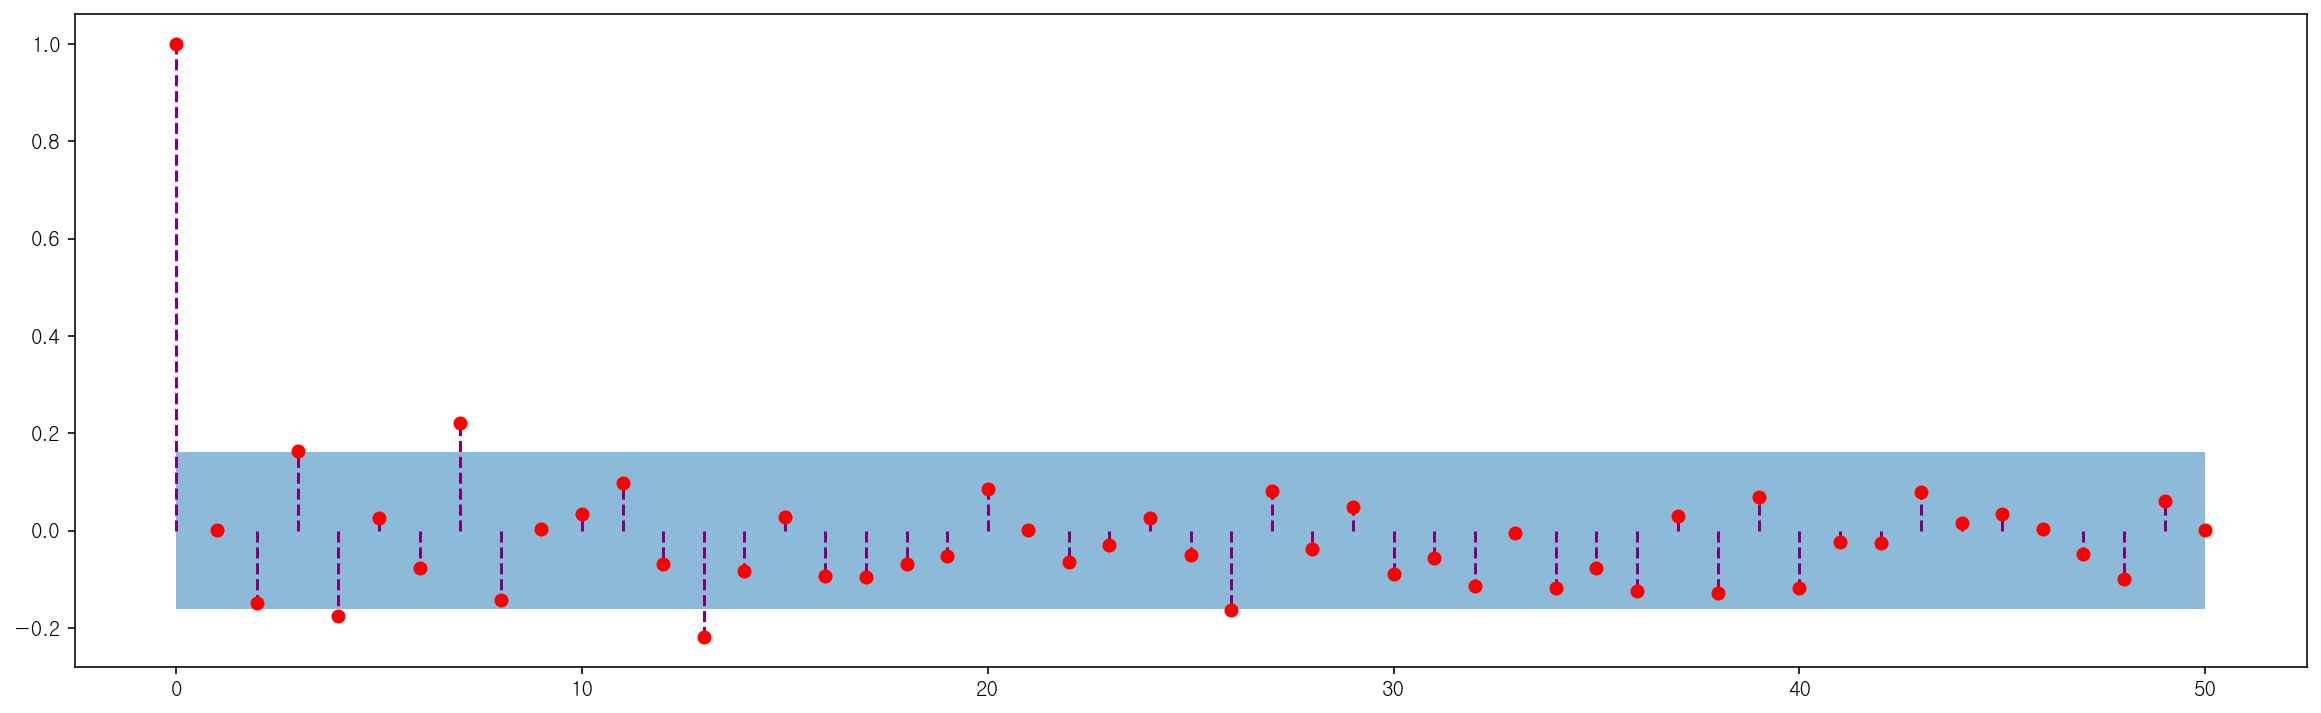

In [134]:
nlags = 50
pacfs = [pacf(log_diff["close"],k) for k in range(nlags+1)]
x = range(nlags+1)
fig = plt.figure(figsize=(20,6))
fig.set_facecolor('white')
 
## correlogram
markers, stemlines, baseline = plt.stem(x, pacfs, use_line_collection=True)
markers.set_color('red')
stemlines.set_linestyle('--')
stemlines.set_color('purple')
baseline.set_visible(False) ## base line 안보이게
 
n = len(log_diff["close"])
upper_limit = 1.96/np.sqrt(n)
lower_limit = -1.96/np.sqrt(n)
plt.fill_between(x, lower_limit, upper_limit, alpha=0.5)
plt.show()

### Modeling

In [135]:
data = log_diff["close"].values
ar_1 = autoRegressiveModel(data,4)

In [136]:
for m in ['CMLE']:
    ar_1.fit(method=m)
    res_str = f'Method : {m}, '
    res_str += f'Intercept : {np.round(ar_1.intercept,4)}, ' 
    for i, p in enumerate(ar_1.phi):
        res_str += f'phi_{i+1} : {np.round(p,4)}, '
    res_str += f'std_error : {np.round(ar_1.std_error,4)} '
    print(res_str)

Method : CMLE, Intercept : -0.0017, phi_1 : 0.0481, phi_2 : -0.1717, phi_3 : 0.1625, phi_4 : -0.1826, std_error : [[0.0802    nan 0.0309    nan]
 [   nan 0.0792    nan 0.0309]
 [0.0309    nan 0.0792    nan]
 [   nan 0.0309    nan 0.0802]] 


In [137]:
fit = AutoReg(data,4).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  148
Model:                     AutoReg(4)   Log Likelihood                 218.687
Method:               Conditional MLE   S.D. of innovations              0.053
Date:                Sat, 17 Dec 2022   AIC                           -425.375
Time:                        18:34:07   BIC                           -407.556
Sample:                             4   HQIC                          -418.134
                                  148                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.004     -0.654      0.513      -0.012       0.006
y.L1           0.0481      0.080      0.598      0.550      -0.110       0.206
y.L2          -0.1717      0.080     -2.142      0.032      -0.329      -0.015
y.L3           0.1625      0.081      2.007      0.045       0.004       0.321
y.L4          -0.1826      0.083     -2.201      0.028      -0.345      -0.020
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.7811           -1.1455j            1.3865           -0.3453
AR.2           -0.7811           +1.1455j            1.3865            0.3453
AR.3            1.2259           -1.1599j            1.6877           -0.1206
AR.4            1.2259           +1.1599j            1.6877            0.1206
-----------------------------------------------------------------------------
"""

<Figure size 576x576 with 0 Axes>

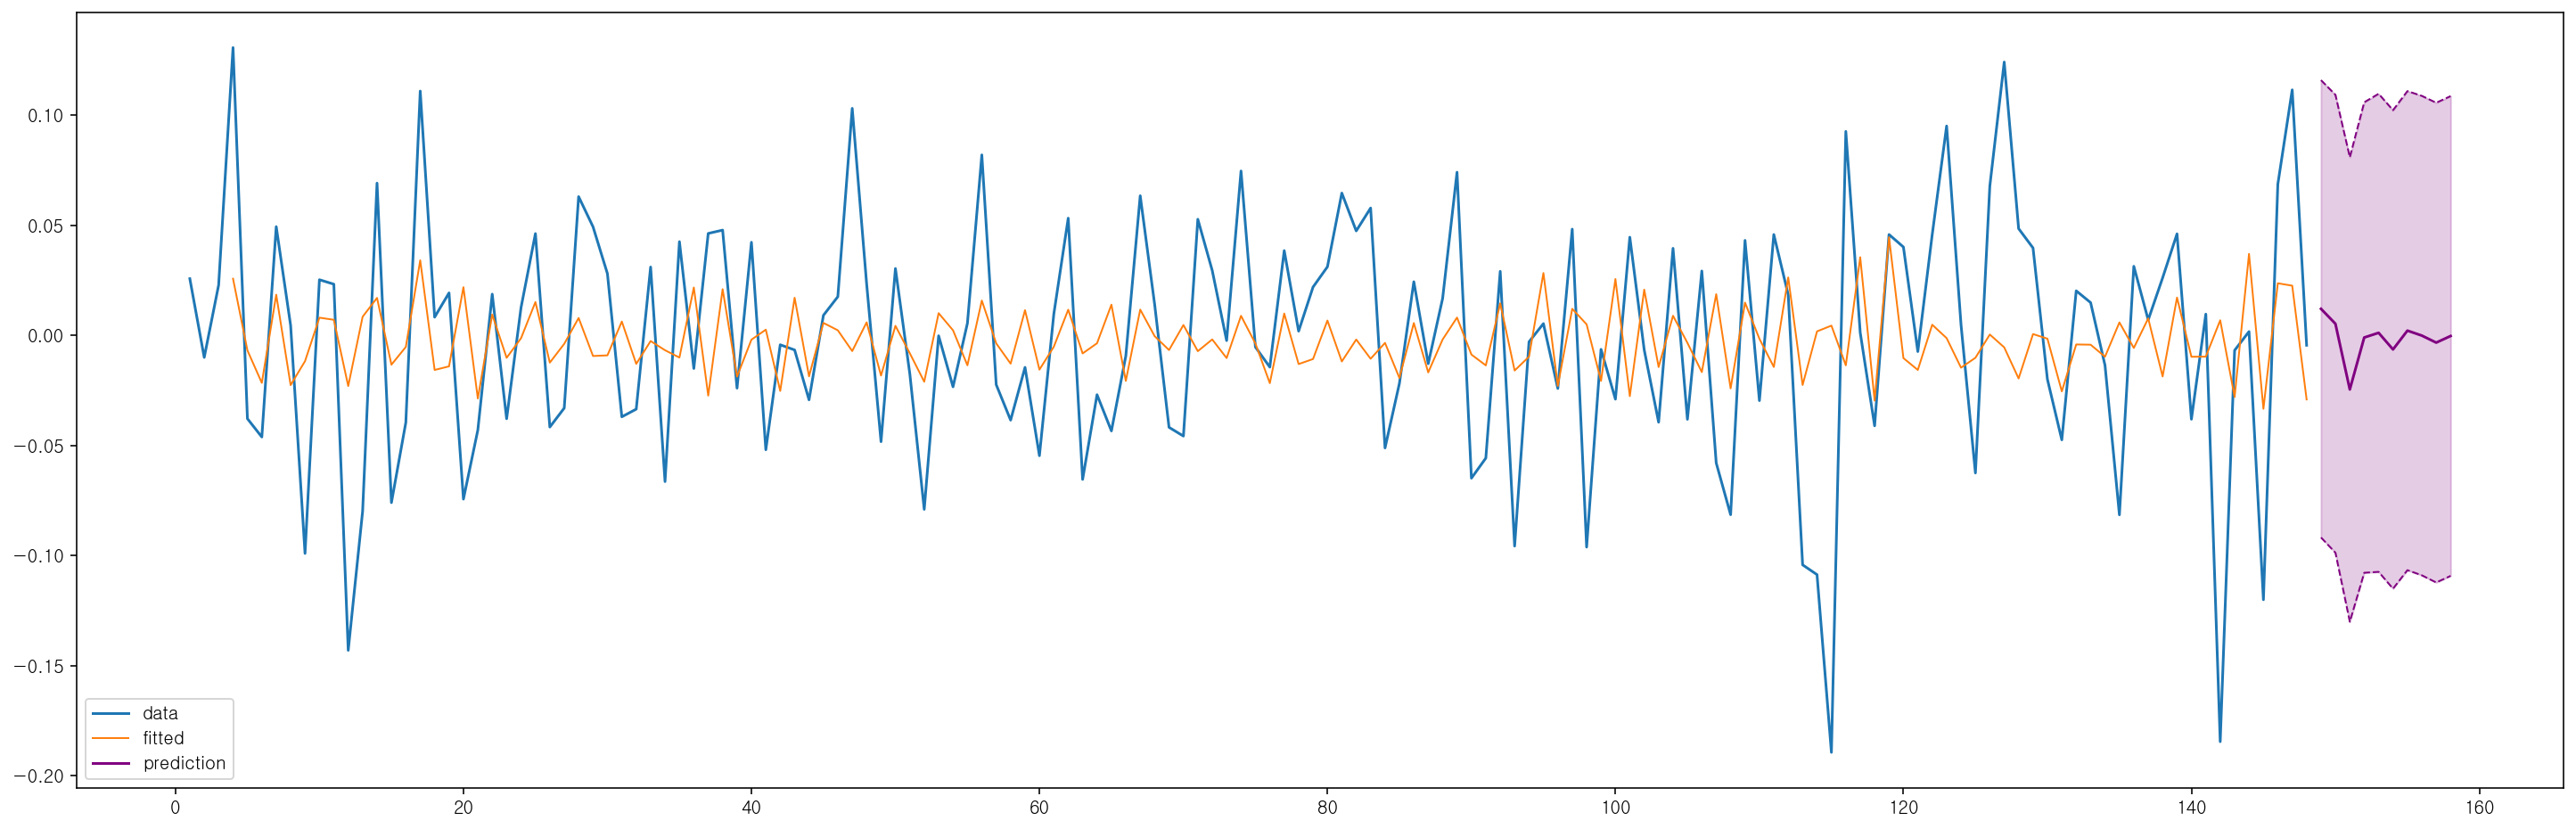

In [138]:
data = log_diff["close"].values
ar_1 = autoRegressiveModel(data,4)
ar_1.fit(method='CMLE')
 
fitted_values = ar_1.fitted_values
fitted_values = np.insert(fitted_values,0,data[0]) ## 적합값
 
k = 10 ## 예측하고자할 예측 시점
 
pred = ar_1.predict(k)
pred_interval =  ar_1.predict_interval(k)
 
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
 
x = range(4,len(data)+1)
x1 = range(1,len(data)+1)
plt.figure(figsize=(25,8))
plt.plot(x1,data,label='data')
plt.plot(x,fitted_values,label='fitted',linewidth=1)
plt.legend(loc = 'best')
## prediction, prediction interval
pred_x = range(len(data)+1,len(data)+k+1)

plt.plot(pred_x,pred,color='purple',label='prediction')
plt.plot(pred_x,pred_interval[0],color='purple',linestyle='--',linewidth=1)
plt.plot(pred_x,pred_interval[1],color='purple',linestyle='--',linewidth=1)
plt.fill_between(pred_x,pred_interval[0],pred_interval[1],color='purple',alpha=0.2)
 
plt.plot()
plt.legend()
plt.show()

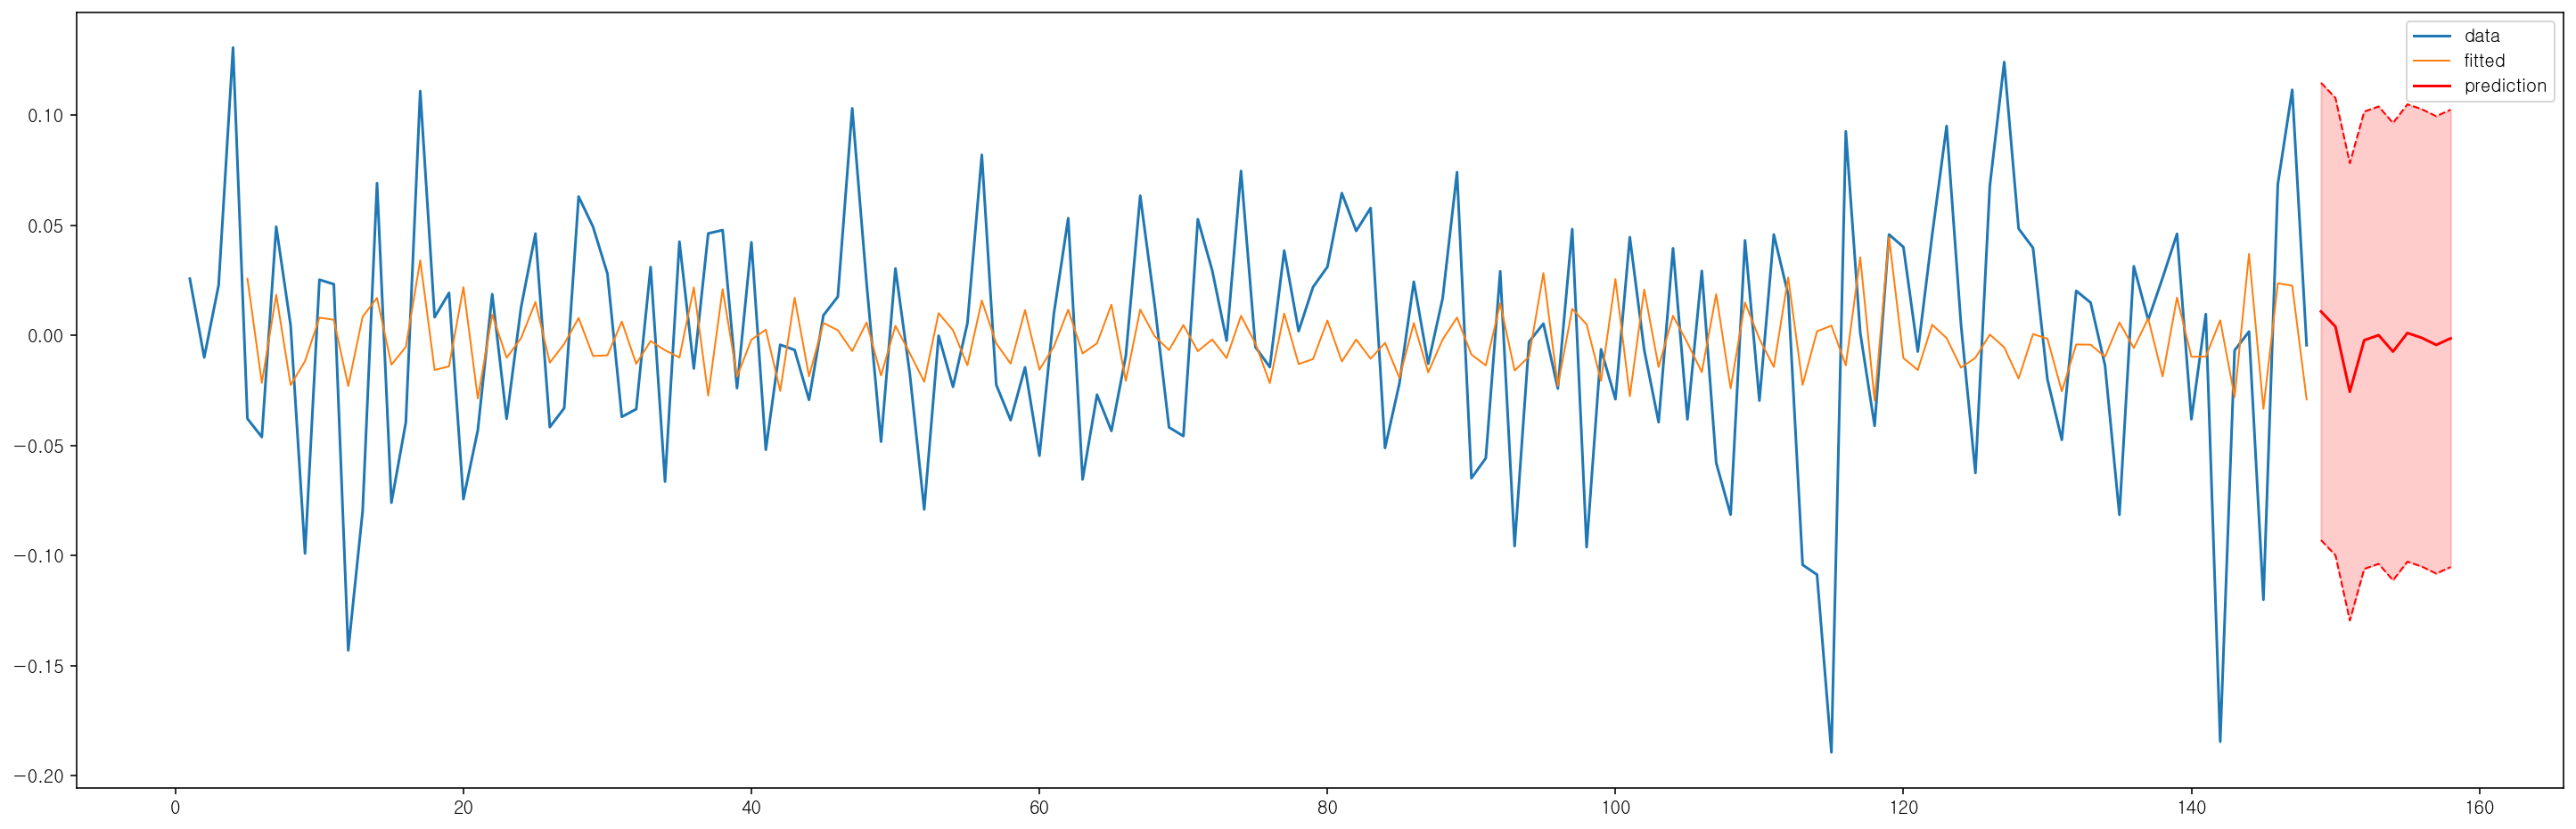

In [139]:
k = 10
alpha = 0.05
pred = fit.predict(start=len(data),end=len(data)+k-1,dynamic=False)
lower_limit = pred - norm.ppf(1-alpha/2)*np.sqrt(fit.sigma2)
upper_limit = pred + norm.ppf(1-alpha/2)*np.sqrt(fit.sigma2)

fitted_values = fit.fittedvalues
fitted_values[0] = data[0] ## 적합값
 
fig = plt.figure(figsize=(25,8))
fig.set_facecolor('white')
 
x = range(5,len(data)+1)
x1 = range(1,len(data)+1)

plt.plot(x1,data,label='data')
plt.plot(x,fitted_values,label='fitted',linewidth=1)
 
## prediction, prediction interval
pred_x = range(len(data)+1,len(data)+k+1)

plt.plot(pred_x,pred,color='red',label='prediction')
plt.plot(pred_x,lower_limit,color='red',linestyle='--',linewidth=1)
plt.plot(pred_x,upper_limit,color='red',linestyle='--',linewidth=1)
plt.fill_between(pred_x,lower_limit,upper_limit,color='red',alpha=0.2)
 
plt.plot()
plt.legend()
plt.show()

### Out_of_bag

In [140]:
data = log_diff.iloc[0:110,1].values
ar_1 = autoRegressiveModel(data,4)

In [141]:
for m in ['CMLE']:
    ar_1.fit(method=m)
    res_str = f'Method : {m}, '
    res_str += f'Intercept : {np.round(ar_1.intercept,4)}, ' 
    for i, p in enumerate(ar_1.phi):
        res_str += f'phi_{i+1} : {np.round(p,4)}, '
    res_str += f'std_error : {np.round(ar_1.std_error,4)} '
    print(res_str)

Method : CMLE, Intercept : -0.0022, phi_1 : -0.0386, phi_2 : -0.2181, phi_3 : 0.1859, phi_4 : -0.1825, std_error : [[0.0916 0.0234 0.0388    nan]
 [0.0234 0.0899 0.0308 0.0388]
 [0.0388 0.0308 0.0899 0.0234]
 [   nan 0.0388 0.0234 0.0916]] 


In [142]:
fit = AutoReg(data,4).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  110
Model:                     AutoReg(4)   Log Likelihood                 178.609
Method:               Conditional MLE   S.D. of innovations              0.045
Date:                Sat, 17 Dec 2022   AIC                           -345.218
Time:                        18:34:08   BIC                           -329.237
Sample:                             4   HQIC                          -338.741
                                  110                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0038      0.004     -0.877      0.380      -0.012       0.005
y.L1          -0.0386      0.092     -0.418      0.676      -0.219       0.142
y.L2          -0.2181      0.090     -2.412      0.016      -0.395      -0.041
y.L3           0.1859      0.092      2.025      0.043       0.006       0.366
y.L4          -0.1825      0.094     -1.943      0.052      -0.367       0.002
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.7377           -1.1020j            1.3261           -0.3439
AR.2           -0.7377           +1.1020j            1.3261            0.3439
AR.3            1.2469           -1.2494j            1.7651           -0.1252
AR.4            1.2469           +1.2494j            1.7651            0.1252
-----------------------------------------------------------------------------
"""

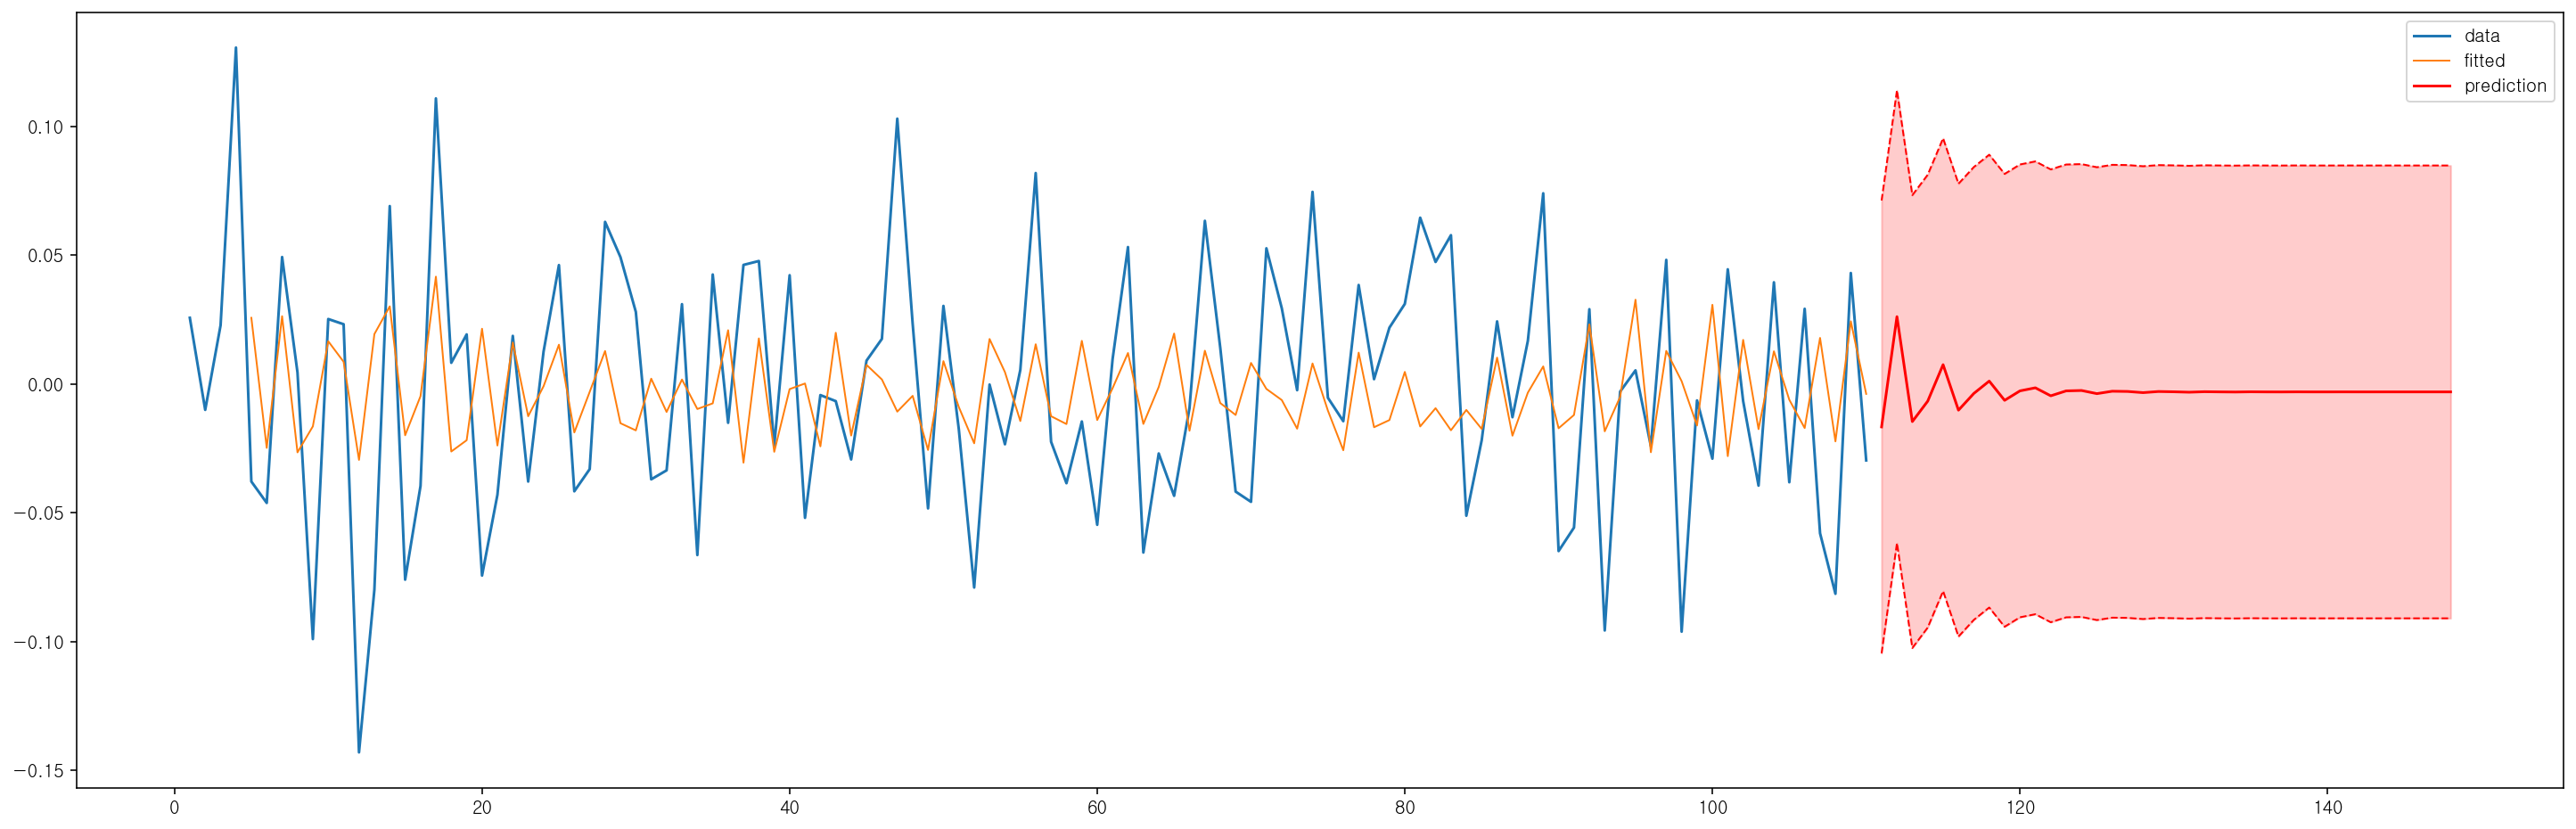

In [143]:
k = 38
alpha = 0.05
pred = fit.predict(start=len(data),end=len(data)+k-1,dynamic=False)
lower_limit = pred - norm.ppf(1-alpha/2)*np.sqrt(fit.sigma2)
upper_limit = pred + norm.ppf(1-alpha/2)*np.sqrt(fit.sigma2)

fitted_values = fit.fittedvalues
fitted_values[0] = data[0] ## 적합값
 
fig = plt.figure(figsize=(25,8))
fig.set_facecolor('white')
 
x = range(5,len(data)+1)
x1 = range(1,len(data)+1)

plt.plot(x1,data,label='data')
plt.plot(x,fitted_values,label='fitted',linewidth=1)
 
## prediction, prediction interval
pred_x = range(len(data)+1,len(data)+k+1)

plt.plot(pred_x,pred,color='red',label='prediction')
plt.plot(pred_x,lower_limit,color='red',linestyle='--',linewidth=1)
plt.plot(pred_x,upper_limit,color='red',linestyle='--',linewidth=1)
plt.fill_between(pred_x,lower_limit,upper_limit,color='red',alpha=0.2)
 
plt.plot()
plt.legend()
plt.show()

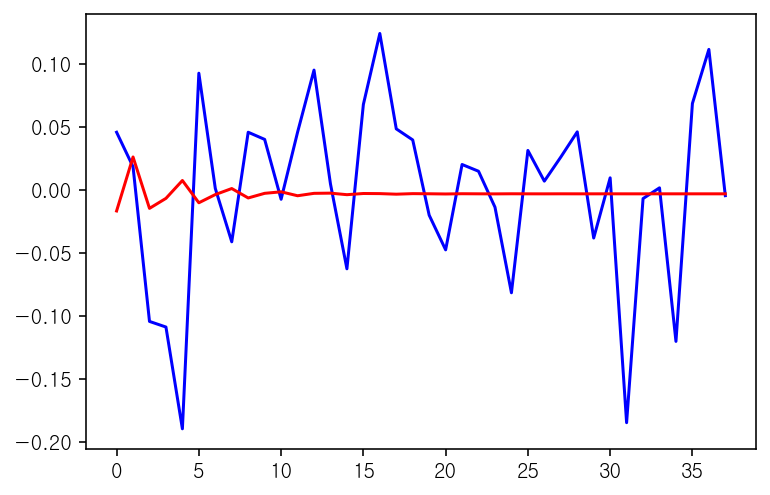

In [144]:
plt.plot(log_diff.iloc[110:148,1].values, color = 'b')
plt.plot(pred, color = 'r')
plt.show()

In [145]:
len(ar_1.fitted_values)

106

In [146]:
len(pred)

38

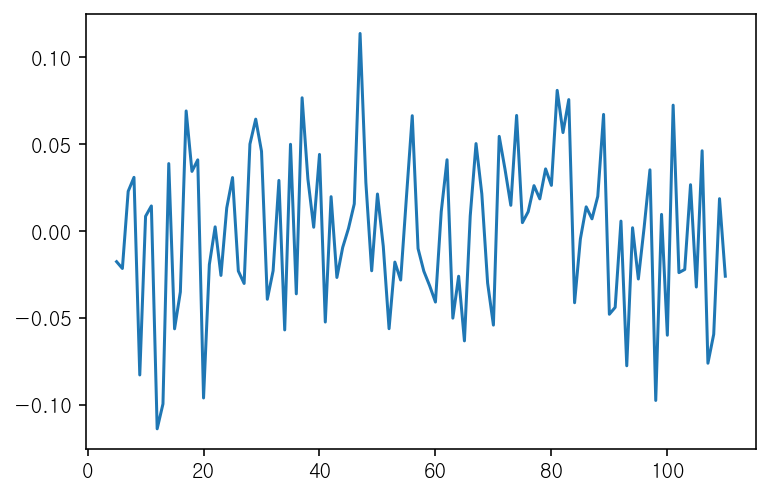

In [147]:
plt.plot(log_diff.iloc[4:110,1] - ar_1.fitted_values)

In [160]:
from statsmodels.tsa.arima.model import ARIMA
data = log_diff["close"].values
final_model  = ARIMA(data ,order = (4,0,4)).fit()
final_model .summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  148
Model:                 ARIMA(4, 0, 4)   Log Likelihood                 232.407
Date:                Sat, 17 Dec 2022   AIC                           -444.813
Time:                        18:50:14   BIC                           -414.841
Sample:                             0   HQIC                          -432.636
                                - 148                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.004     -0.443      0.658      -0.010       0.006
ar.L1          0.0152      0.421      0.036      0.971      -0.809       0.840
ar.L2         -0.4091      0.268     -1.529      0.126      -0.934       0.115
ar.L3         -0.2009      0.309     -0.651      0.515      -0.806       0.404
ar.L4          0.2180      0.279      0.781      0.435      -0.329       0.765
ma.L1          0.0708      0.393      0.180      0.857      -0.699       0.841
ma.L2          0.2848      0.289      0.986      0.324      -0.281       0.851
ma.L3          0.4692      0.306      1.531      0.126      -0.131       1.070
ma.L4         -0.5731      0.366     -1.565      0.118      -1.291       0.145
sigma2         0.0025      0.000      8.156      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 5.07
Prob(Q):                              0.91   Prob(JB):                         0.08
Heteroskedasticity (H):               1.69   Skew:                            -0.38
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

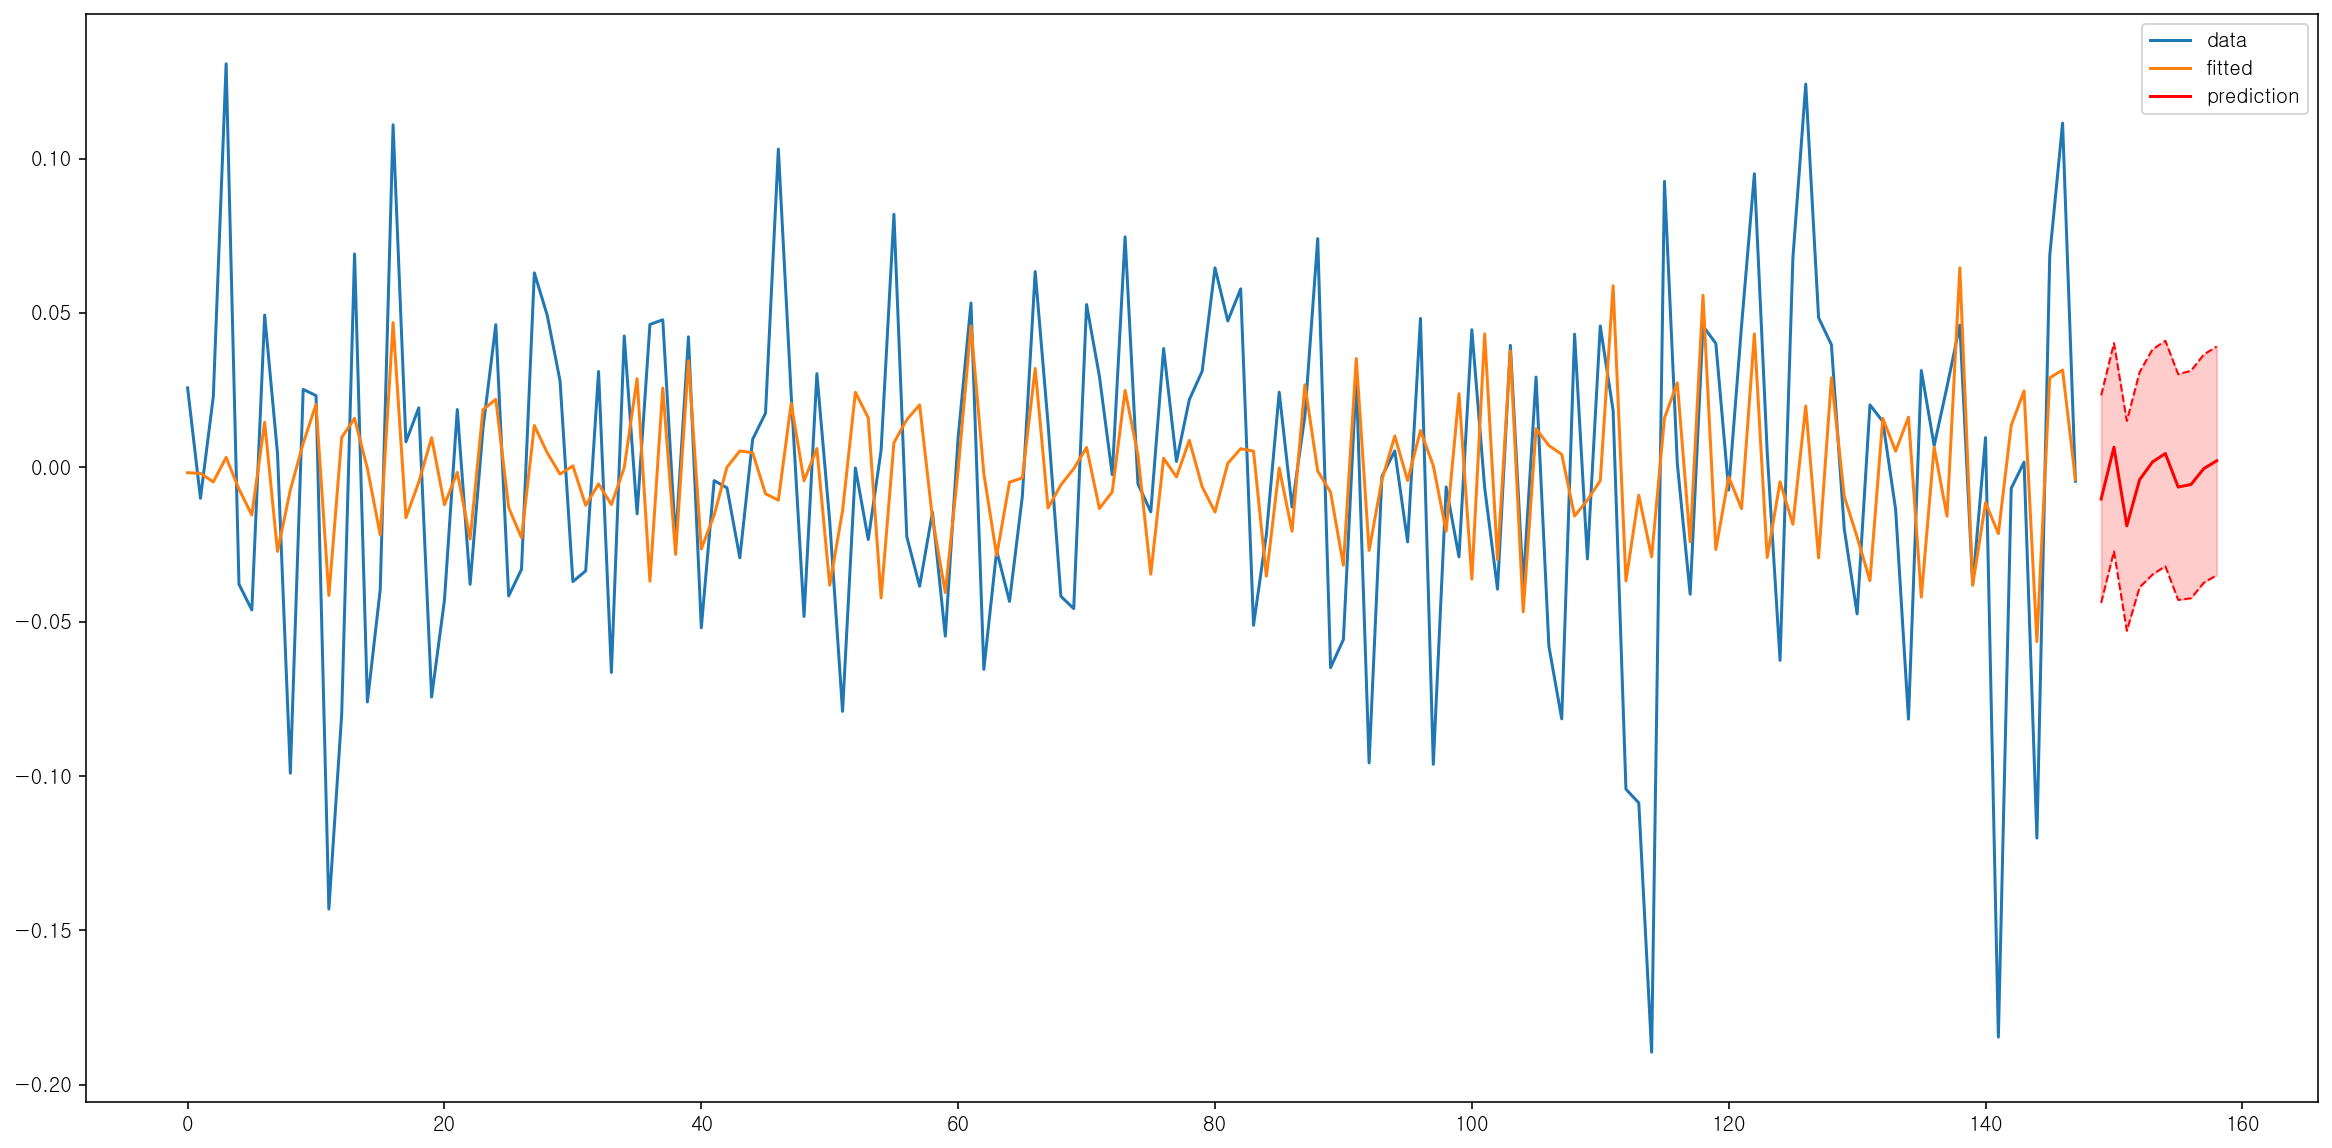

In [162]:
fig = plt.figure(figsize=(20,10))
fig.set_facecolor('white')
 
fitted_values = final_model.fittedvalues ## in-sample prediction
 
## prediction
k = 10
 
forecast = final_model.get_forecast(k) ## out-of-sample prediction
predicted_values = forecast.predicted_mean
prediction_intervals = forecast.conf_int(alpha=0.5)
upper_limit = [x[1] for x in prediction_intervals]
lower_limit = [x[0] for x in prediction_intervals]
 
pred_x = range(len(data)+1, len(data)+k+1)
 
plt.plot(range(len(data)), data, label = 'data')
plt.plot(range(len(data)), fitted_values, label='fitted')
plt.plot(pred_x,predicted_values,color='red',label='prediction')
plt.plot(pred_x,lower_limit,color='red',linestyle='--',linewidth=1)
plt.plot(pred_x,upper_limit,color='red',linestyle='--',linewidth=1)
plt.fill_between(pred_x,lower_limit,upper_limit,color='red',alpha=0.2)
plt.legend()
 
plt.show()